# Clustering analysis for building a stable investment portfolio


## Libraries import

In [ ]:
from IPython.display import clear_output

In [ ]:
!pip install PyPortfolioOpt
clear_output()

In [ ]:
# !pip install yfinance --upgrade --no-cache-dir

In [ ]:
import pandas as pd
import numpy as np

import requests
import copy

from datetime import timedelta, datetime

from collections import OrderedDict

import yfinance as yf

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler


from pypfopt import base_optimizer
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import pypfopt.plotting as pplt


import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline

## Loading the data

### Methods for loading from Wikipedia

In [ ]:
# Скачиваем список тикеров акций из индекса S&P 500 из Википедии

def get_tickers():
    wiki_page = requests.get(
        'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    ).text

    sp_data = pd.read_html(wiki_page)
    ticker_df = sp_data[0]
    ticker_options = ticker_df['Symbol']

    return ticker_options

In [ ]:
# Вызываем функцию get_tickers
# Конвертируем полученный результат в список и заменяем
# тикеры, у которых есть '.' знаком '-', чтобы скачать данные из библиотеки

stock_tickers = get_tickers()
stock_tickers = stock_tickers.to_list()
for ticker in range(len(stock_tickers)):
    stock_tickers[ticker] = stock_tickers[ticker].upper().replace(".", "-")

print (len(stock_tickers))

503


### 200 largest companies from S&P 500

In [ ]:
# https://drive.google.com/file/d/1LMPB6_Fh0zirN3Jwe-rMMGM70MgEYq2q/view?usp=share_link

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1LMPB6_Fh0zirN3Jwe-rMMGM70MgEYq2q' -O tickers-top-200.csv

--2023-05-13 23:35:06--  https://docs.google.com/uc?export=download&id=1LMPB6_Fh0zirN3Jwe-rMMGM70MgEYq2q
Resolving docs.google.com (docs.google.com)... 209.85.200.100, 209.85.200.139, 209.85.200.113, ...
Connecting to docs.google.com (docs.google.com)|209.85.200.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/67bm7cl2m5e0906fj6kfmggsni8t5vpn/1684020900000/11915959673283641640/*/1LMPB6_Fh0zirN3Jwe-rMMGM70MgEYq2q?e=download&uuid=6189d5fa-e662-4820-9ed3-1fd040686903 [following]
--2023-05-13 23:35:06--  https://doc-0k-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/67bm7cl2m5e0906fj6kfmggsni8t5vpn/1684020900000/11915959673283641640/*/1LMPB6_Fh0zirN3Jwe-rMMGM70MgEYq2q?e=download&uuid=6189d5fa-e662-4820-9ed3-1fd040686903
Resolving doc-0k-60-docs.googleusercontent.com (doc-0k-60-docs.googleusercontent.com)... 142.251.120.132, 2607:f8b0

In [ ]:
stock_tickers = pd.read_csv('tickers-top-200.csv', header=None)

In [ ]:
stock_tickers

,0
0,AAPL
1,MSFT
2,AMZN
3,NVDA
4,GOOGL
...,...
195,LHX
196,HLT
197,CHTR
198,NUE


In [ ]:
stock_tickers = list(stock_tickers[0].values)

In [ ]:
for ticker in range(len(stock_tickers)):
    stock_tickers[ticker] = stock_tickers[ticker].upper().replace(".", "-")

In [ ]:
type(stock_tickers)

list

### yfinance library

In [ ]:
df_stocks= yf.download(stock_tickers,
                       start='2019-01-01',
                       end='2023-04-01')['Adj Close']

[*********************100%***********************]  200 of 200 completed


In [ ]:
df_stocks.index = pd.to_datetime(df_stocks.index)

In [ ]:
df_stocks.isna().sum().sum()

152

In [ ]:
df_stocks.T

Date,2019-01-02,2019-01-03,2019-01-04,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,2019-01-14,2019-01-15,...,2023-03-20,2023-03-21,2023-03-22,2023-03-23,2023-03-24,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31
A,63.738388,61.390293,63.515240,64.863930,65.814819,67.192642,67.823326,68.289055,67.677765,68.502525,...,134.321167,136.787155,133.512497,130.916733,131.745377,132.853577,132.414291,133.632309,134.271271,138.114990
AAPL,37.994495,34.209957,35.670361,35.590965,36.269444,36.885349,37.003250,36.639950,36.088997,36.827618,...,157.182587,159.059982,157.612000,158.710464,160.028656,158.061371,157.432236,160.547943,162.135742,164.672226
ABBV,72.144714,69.767654,72.015343,73.066422,73.405991,70.996620,71.311928,71.400856,69.371132,69.976776,...,154.696884,155.340958,152.269211,153.884369,156.579575,156.103928,156.807465,156.559753,156.480469,157.917252
ABT,64.570137,61.522793,63.278736,64.226372,63.455273,64.514412,64.179916,64.412193,63.721497,65.774918,...,97.383324,97.841034,96.378342,96.557449,97.562431,97.970390,96.627106,98.129593,98.587311,100.756470
ACN,132.098801,127.588684,132.549820,133.010208,136.373993,137.059891,138.140442,137.398132,136.176636,138.018311,...,251.562134,256.612305,252.279327,270.597382,270.936066,272.888367,273.924316,278.845001,281.554352,284.692047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WM,82.377487,82.154640,84.336647,84.540916,85.738693,85.302315,86.527939,86.955048,86.453651,87.075760,...,154.869995,154.509995,152.089996,150.699997,154.460007,153.580002,154.820007,157.039993,161.529999,163.169998
WMT,86.520981,86.076035,86.613663,87.633301,88.245087,87.957718,88.022614,87.911385,88.013359,89.218384,...,140.366776,139.888596,138.992004,140.117722,141.263382,143.624405,143.066528,143.684174,145.118729,146.891998
XEL,42.937183,42.767998,43.186508,42.999512,43.498158,43.150883,43.872143,43.889961,43.569401,44.424229,...,67.389999,65.500000,64.150002,63.310001,65.550003,65.290001,65.400002,66.540001,66.910004,67.440002
XOM,55.378765,54.528496,56.538948,56.832966,57.246185,57.548153,57.254135,56.991901,56.920376,56.952164,...,102.449997,107.040001,104.589996,103.410004,103.529999,105.800003,107.120003,108.959999,109.489998,109.660004


In [ ]:
df_stocks = df_stocks.ffill(axis=1)

In [ ]:
df_stocks.isna().sum().sum()

0

### S&P 500 index rates

In [ ]:
# https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks?resource=download&select=sp500_companies.csv

In [ ]:
# https://drive.google.com/file/d/1Ud1CScA1EGpbEasKK0dzl1Kc1qIDFRQy/view?usp=sharing

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Ud1CScA1EGpbEasKK0dzl1Kc1qIDFRQy' -O sp500_index.csv

--2023-05-13 23:18:32--  https://docs.google.com/uc?export=download&id=1Ud1CScA1EGpbEasKK0dzl1Kc1qIDFRQy
Resolving docs.google.com (docs.google.com)... 209.85.200.100, 209.85.200.102, 209.85.200.113, ...
Connecting to docs.google.com (docs.google.com)|209.85.200.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/dv8fav1bel9lfmqagh9ja1e9m2vah4ra/1684019850000/11915959673283641640/*/1Ud1CScA1EGpbEasKK0dzl1Kc1qIDFRQy?e=download&uuid=4720b55d-5bc6-4368-b268-4e273e354876 [following]
--2023-05-13 23:18:32--  https://doc-0c-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/dv8fav1bel9lfmqagh9ja1e9m2vah4ra/1684019850000/11915959673283641640/*/1Ud1CScA1EGpbEasKK0dzl1Kc1qIDFRQy?e=download&uuid=4720b55d-5bc6-4368-b268-4e273e354876
Resolving doc-0c-60-docs.googleusercontent.com (doc-0c-60-docs.googleusercontent.com)... 142.251.161.132, 2607:f8b0

In [ ]:
index_df = pd.read_csv('sp500_index.csv')
index_df.index = pd.to_datetime(index_df['Date'])
index_df = index_df.drop('Date', axis=1)

In [ ]:
index_df

,S&P500
Date,
2013-05-03,1614.42
2013-05-06,1617.50
2013-05-07,1625.96
2013-05-08,1632.69
2013-05-09,1626.67
...,...
2023-04-26,4055.99
2023-04-27,4135.35
2023-04-28,4169.48


## Additional methods

### Methods for clustering

In [ ]:
def get_corr_dissimilarity_matrix(stocks_df: pd.DataFrame) -> np.ndarray:
    corr = np.corrcoef(stocks_df.T)
    corr = (corr + corr.T) / 2
    np.fill_diagonal(corr, 1)
    dissimilarity = np.sqrt(2 * (1 - corr))
    np.triu(dissimilarity)

    return np.triu(dissimilarity)

In [ ]:
def get_df_between_dates(stocks_df: pd.DataFrame,
                         start_date: str,
                         end_date: str,
                         time_delta: int = 0) -> pd.DataFrame:

    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')

    stocks_df = stocks_df.copy()
    stocks_df['date'] = stocks_df.index
    stocks_df = stocks_df[
        (stocks_df['date'] >= start_date) &
        (stocks_df['date'] - timedelta(days=time_delta) <= end_date)
    ].drop('date', axis=1)

    return stocks_df

In [ ]:
def calinski_harabasz_method(data: pd.DataFrame,
                             linkage: str) -> None:

    wcss = []
    for i in range(2, 50):
        clust = AgglomerativeClustering(n_clusters = i, linkage = linkage)
        labels = clust.fit_predict(data)
        wcss.append(calinski_harabasz_score(data, labels))
    plt.plot(range (2, 50), wcss)
    plt.title('The CH score')
    plt.xlabel('Number of clusters')
    plt.ylabel('CH score')
    plt.show()

In [ ]:
def print_clusters(df_combined, cluster_labels):
  cluster_dict = {}
  for i, label in enumerate(cluster_labels):
      if label not in cluster_dict:
          cluster_dict[label] = []
      cluster_dict[label].append(df_combined.columns[i])

  # Print out the companies in each cluster
  for cluster, companies in cluster_dict.items():
      print(f"Cluster {cluster}: {', '.join(companies)}")
  return cluster_dict

In [ ]:
def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

### Methods for optimization

In [ ]:
def optimize_portfolio(stocks_df: pd.DataFrame,
                       portfolio: list,
                       weight_bounds: tuple) -> OrderedDict:

    mu = expected_returns.mean_historical_return(stocks_df[portfolio])
    sigma = risk_models.sample_cov(stocks_df[portfolio])

    ef = EfficientFrontier(mu, sigma, weight_bounds=weight_bounds)
    sharpe_pfolio=ef.max_sharpe()
    sharpe_pwt=ef.clean_weights()
    print(sharpe_pwt)
    print()
    ef.portfolio_performance(verbose=True)

    return sharpe_pwt

In [ ]:
def get_sharpe_ratio_info(stocks_df: pd.DataFrame) -> pd.DataFrame:

    returns = expected_returns.mean_historical_return(stocks_df)
    returns = returns.reset_index()
    returns.columns = ['ticker', 'mean_return']

    risk_free_rate = 0.02

    variance = risk_models.sample_cov(stocks_df)
    returns['var'] = np.array(variance).diagonal()

    returns['sharpe_ratio'] = (returns['mean_return'] -
                               risk_free_rate) / returns['var']

    return returns

In [ ]:
def get_portfolio_tickers(cluster_dict: dict,
                          sharpe_ratio_df: pd.DataFrame) -> list:

    portfolio = []
    for label in cluster_dict:
        cluster = sharpe_ratio_df[returns['ticker'].isin(cluster_dict[label])]

        portfolio.append(
            cluster.iloc[cluster['sharpe_ratio'].argmax()]['ticker']
        )

    return portfolio

In [ ]:
def calculate_port_cum_return(stocks_df: pd.DataFrame,
                              portfolio: list,
                              weights: OrderedDict) -> float:
    port_cum_ret = []
    for stock in portfolio:
        port_cum_ret.append(
            (stocks_df[stock][-1] - stocks_df[stock][0]) / stocks_df[stock][0]
            )

    port_cum_ret = pd.DataFrame(port_cum_ret,
                                index=portfolio,
                                columns=['cum_ret'])

    port_cum_ret['weight'] = list(weights.values())

    return (port_cum_ret['cum_ret'] * port_cum_ret['weight']).sum()

In [ ]:
def get_portfolio_beta_coef(stocks_df: pd.DataFrame,
                            index_df: pd.DataFrame,
                            portfolio: list,
                            weights: OrderedDict) -> float:

    stocks = stocks_df.copy()
    returns = expected_returns.returns_from_prices(stocks[portfolio])
    weights = pd.DataFrame(weights, index=[0])
    for stock in portfolio:
        returns[stock] = returns[stock] * weights[stock].values[0]

    returns = np.array(returns.sum(axis=1))

    index_returns = np.squeeze(expected_returns.returns_from_prices(index_df))

    beta = np.cov(returns, index_returns)[0][1] / np.var(index_returns)

    return beta

In [ ]:
def get_portfolio_stats(stocks_df: pd.DataFrame,
                        index_df: pd.DataFrame,
                        start_date: str,
                        end_date: str,
                        portfolio: list,
                        weights: OrderedDict) -> None:

    df = get_df_between_dates(stocks_df,
                              start_date,
                              end_date)

    index = get_df_between_dates(index_df,
                                 start_date,
                                 end_date)

    exp_returns = expected_returns.mean_historical_return(df[portfolio],
                                                          frequency=df.shape[0])

    cov_matrix = risk_models.sample_cov(df[portfolio],
                                        frequency=df.shape[0])

    print('==================')
    print('Portfolio stats')
    print('==================')
    print(base_optimizer.portfolio_performance(weights,
                                               exp_returns,
                                               cov_matrix,
                                               verbose=True,
                                               risk_free_rate=0))


    print(f'Beta: {get_portfolio_beta_coef(df, index, portfolio, weights)}')

    cum_return = np.round(
        calculate_port_cum_return(df, portfolio, weights) * 100, 2)

    print(f'Cumulative return: {cum_return}%')

    print('==================')
    print('Index stats')
    print('==================')

    index_values = np.squeeze(index.values)

    index_return = np.round(
        (index_values[-1] - index_values[0]) / index_values[0] * 100, 1
    )
    index_returns = np.squeeze(expected_returns.returns_from_prices(index))

    index_var = np.round(np.var(index_returns) * 100, 1)
    # sharpe = np.round(index_return / index_var, 2)

    print(f'Expected return: {index_return}%')
    print(f'Volatility: {index_var}%')
    # print(f'Sharpe Ratio: {sharpe}')
    print('==================')

In [ ]:
def iterate_over_period(stocks_df: pd.DataFrame,
                        portfolio: list,
                        weight_bounds: tuple,
                        time_delta: int,
                        start_date: str,
                        end_date: str) -> None:

    len_loop = get_df_between_dates(stocks_df,
                                    start_date,
                                    end_date).shape[0]
    cum_returns = []
    volatilities = []
    for i in range(len_loop):

        if i % time_delta == 0:
            period = get_df_between_dates(stocks_df,
                                          start_date,
                                          end_date,
                                          i)

            mu = expected_returns.mean_historical_return(
                period[portfolio],
                frequency=len_loop
            )

            sigma = risk_models.sample_cov(period[portfolio],
                                           frequency=len_loop)

            ef = EfficientFrontier(mu, sigma, weight_bounds=weight_bounds)
            sharpe_pfolio=ef.max_sharpe()
            weights=ef.clean_weights()

            cum_return_df = get_df_between_dates(stocks_df,
                                                 start_date,
                                                 start_date,
                                                 i)

            cum_returns.append(
                calculate_port_cum_return(cum_return_df, portfolio, weights)
            )

            volatility = base_optimizer.portfolio_performance(
                weights, mu,
                sigma, verbose=False, risk_free_rate=0
            )[1]

            volatilities.append(volatility)

    if len(cum_returns)!= 0:
        print(cum_returns[-1])
        print(volatilities[-1])
        plt.plot(np.arange(1, len_loop / time_delta  + 1),
                 cum_returns,
                 label='returns')

        plt.plot(np.arange(1, len_loop / time_delta + 1),
                 volatilities,
                 label='volatility')

        plt.legend()
        plt.show()

## Period 1 - stable (year 2021)


In [ ]:
stocks_df = get_df_between_dates(df_stocks,
                                 '2020-06-01',
                                 '2021-06-01')

In [ ]:
returns = get_sharpe_ratio_info(get_df_between_dates(df_stocks,
                                                     '2019-01-01',
                                                     '2021-06-01'))

In [ ]:
returns

,ticker,mean_return,var,sharpe_ratio
0,A,0.367897,0.088479,3.931986
1,AAPL,0.627693,0.133719,4.544555
2,ABBV,0.162033,0.088930,1.597136
3,ABT,0.210379,0.091061,2.090674
4,ACN,0.352340,0.090796,3.660299
...,...,...,...,...
195,WM,0.230104,0.063712,3.297717
196,WMT,0.211367,0.055996,3.417494
197,XEL,0.196920,0.079107,2.236469
198,XOM,0.005347,0.149267,-0.098168


### Portfolio without clustering

In [ ]:
port = list(df_stocks.columns)

In [ ]:
sharpe_pwt = optimize_portfolio(stocks_df, port, (0, 1))

OrderedDict([('A', 0.0), ('AAPL', 0.0), ('ABBV', 0.0), ('ABT', 0.0), ('ACN', 0.0), ('ADBE', 0.0), ('ADI', 0.0), ('ADM', 0.0), ('ADP', 0.0), ('ADSK', 0.0), ('AEP', 0.0), ('AIG', 0.0), ('AJG', 0.0), ('AMAT', 0.0), ('AMD', 0.0), ('AMGN', 0.0), ('AMT', 0.0), ('AMZN', 0.0), ('ANET', 0.0), ('AON', 0.0), ('APD', 0.0), ('APH', 0.0), ('ATVI', 0.0), ('AVGO', 0.0), ('AXP', 0.0), ('AZO', 0.0), ('BA', 0.0), ('BAC', 0.0), ('BDX', 0.0), ('BIIB', 0.0), ('BKNG', 0.0), ('BLK', 0.0), ('BMY', 0.0), ('BRK-B', 0.0), ('BSX', 0.0), ('C', 0.0), ('CAT', 0.0), ('CB', 0.0), ('CCI', 0.0), ('CDNS', 0.0), ('CHTR', 0.0), ('CI', 0.0), ('CL', 0.0), ('CMCSA', 0.0), ('CME', 0.0), ('CMG', 0.0), ('COF', 0.0), ('COP', 0.0), ('COST', 0.0), ('CRM', 0.0), ('CSCO', 0.0), ('CSX', 0.0), ('CTAS', 0.0), ('CTVA', 0.0), ('CVS', 0.0), ('CVX', 0.0), ('D', 0.0), ('DE', 0.04578), ('DG', 0.0), ('DHR', 0.0), ('DIS', 0.0), ('DOW', 0.0), ('DUK', 0.0), ('DXCM', 0.0), ('ECL', 0.0), ('EL', 0.0), ('ELV', 0.0), ('EMR', 0.0), ('EOG', 0.0), ('EQIX'

In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-06-01',
                    '2021-07-01',
                    port,
                    sharpe_pwt)

Portfolio stats
Expected annual return: -1.8%
Annual volatility: 5.2%
Sharpe Ratio: -0.35
(-0.018297919735790542, 0.051943561199540036, -0.35226540716951404)
Beta: 1.1352172504394846
Cumulative return: -1.79%
Index stats
Expected return: 2.8%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-07-01',
                    '2021-08-01',
                    port,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 5.2%
Annual volatility: 5.6%
Sharpe Ratio: 0.92
(0.05202904669700025, 0.056461884805884446, 0.9214897248980571)
Beta: 1.2948576105669045
Cumulative return: 4.91%
Index stats
Expected return: 1.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-08-01',
                    '2021-09-01',
                    port,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 1.5%
Annual volatility: 5.8%
Sharpe Ratio: 0.27
(0.01540325964210005, 0.057805828919699154, 0.26646550927411583)
Beta: 1.709385899644241
Cumulative return: 1.47%
Index stats
Expected return: 3.1%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-06-01',
                    '2021-08-01',
                    port,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 4.2%
Annual volatility: 7.6%
Sharpe Ratio: 0.55
(0.041595950119728005, 0.0757137232722212, 0.5493845543716545)
Beta: 1.1973721402087831
Cumulative return: 3.99%
Index stats
Expected return: 4.6%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-06-01',
                    '2021-09-01',
                    port,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 4.8%
Annual volatility: 9.5%
Sharpe Ratio: 0.50
(0.0476950513396935, 0.0954142079900111, 0.49987368070682603)
Beta: 1.3224092795565099
Cumulative return: 4.63%
Index stats
Expected return: 7.7%
Volatility: 0.0%


##### Extra

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:10474: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:10474: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide 

0.2074126242609774
0.052228960136477875


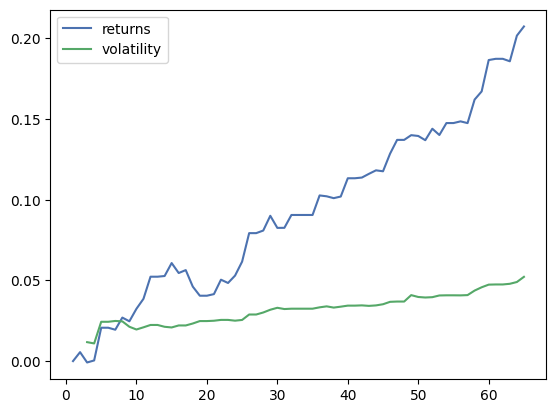

In [ ]:
iterate_over_period(df_stocks, port, 1, '2021-03-01', '2021-06-01')

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:10474: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/pypfopt/risk_models.py:68: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/pypfopt/risk_models.py:68: UserWarning: T

0.2074126242609774
0.052228960136477875


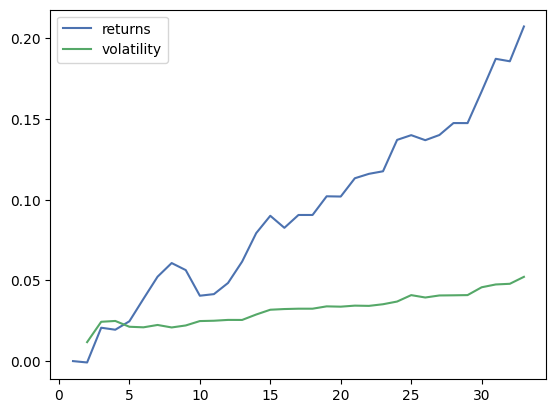

In [ ]:
iterate_over_period(df_stocks, port, 2, '2021-03-01', '2021-06-01')

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:10474: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/pypfopt/risk_models.py:68: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


0.18736945095916474
0.047509055678986924


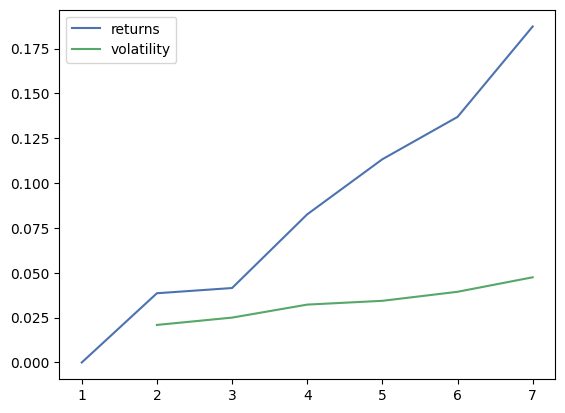

In [ ]:
iterate_over_period(df_stocks, port, 10, '2021-03-01', '2021-06-01')

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:10474: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/pypfopt/risk_models.py:68: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


0.18736945095916474
0.047509055678986924


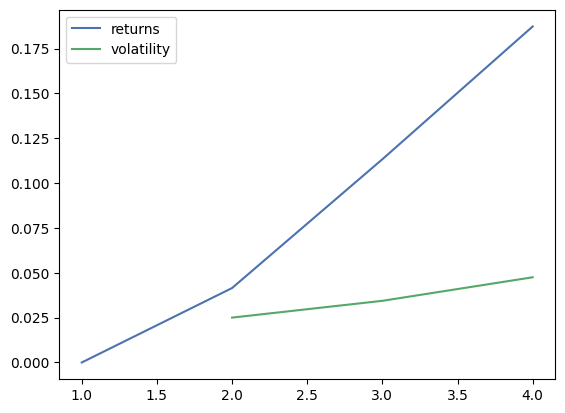

In [ ]:
iterate_over_period(df_stocks, port, 20, '2021-03-01', '2021-06-01')

### Correlation

In [ ]:
dissimilarity = get_corr_dissimilarity_matrix(stocks_df)

In [ ]:
dissimilarity

array([[0.        , 0.5700874 , 0.5552682 , ..., 1.32845332, 0.78490795,
        0.74819387],
       [0.        , 0.        , 0.9063419 , ..., 1.28402291, 1.14552316,
        0.64987327],
       [0.        , 0.        , 0.        , ..., 1.49163139, 0.56270081,
        1.08317826],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 1.54859176,
        0.89449845],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.2845769 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

#### Ward linkage

##### Building a portfolio

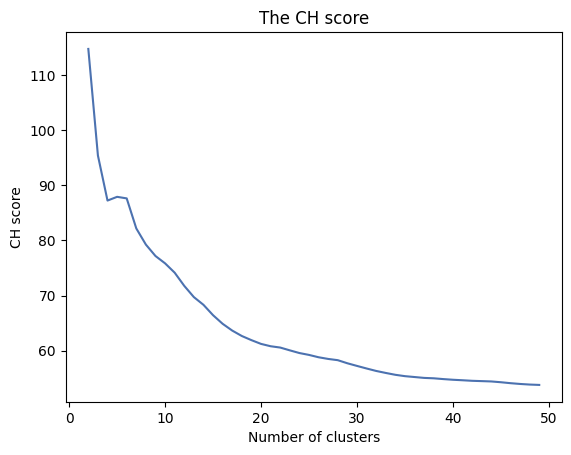

In [ ]:
calinski_harabasz_method(dissimilarity, 'ward')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 6, linkage='ward')
labels = clust.fit_predict(dissimilarity)

In [ ]:
calinski_harabasz_score(dissimilarity, labels) # 6

87.61691333607044

In [ ]:
cluster_dict = print_clusters(stocks_df, labels)

Cluster 0: A, AAPL, ABBV, ABT, ACN, ADI, ADM, ADP, ADSK, AIG, AJG, AMAT, ANET, AON, APH, ATVI, AVGO, AXP, AZO, BA, BAC, BKNG, BLK, BMY, BRK-B, BSX, C, CAT, CB, CCI, CDNS, CHTR, CI, CL, CMCSA, CME, CMG, COF, COP, COST, CRM, CSCO, CSX, CTAS, CTVA, CVS, CVX, DG
Cluster 5: ADBE, AEP, AMD, AMGN, AMT, AMZN, APD, BDX, BIIB
Cluster 1: D, DXCM, EQIX, GILD, GIS, KMB, LMT, MRK
Cluster 3: DE, DHR, DIS, DOW, DUK, ECL, EL, ELV, EMR, EOG, ETN, EW, EXC, F, FCX, FDX, FISV, FTNT, GD, GE, GM, GOOG, GOOGL, GS, HCA, HD, HES, HLT, HON, HSY, HUM, IBM, ICE, IDXX, INTC, INTU, ISRG, ITW, JCI, JNJ, JPM, KLAC
Cluster 2: KO, LHX, LIN, LLY, LOW, LRCX, MA, MAR, MCD, MCHP, MCK, MCO, MDLZ, MDT, MET, META, MMC, MMM, MNST, MO, MPC, MRNA, MS, MSCI, MSFT, MSI, MU, NEE, NEM, NFLX, NKE, NOC, NOW, NSC, NUE, NVDA, NXPI, O, ORCL, ORLY, OXY, PEP, PFE, PG, PGR, PH, PLD, PM, PNC, PSA, PSX, PXD, PYPL, QCOM, REGN
Cluster 4: ROP, RTX, SBUX, SCHW, SHW, SLB, SNPS, SO, SPGI, SRE, SYK, SYY, T, TDG, TEL, TFC, TGT, TJX, TMO, TMUS, TRV, TS

In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio

['COST', 'AMZN', 'GIS', 'DHR', 'MSFT', 'TGT']

In [ ]:
returns[returns['ticker'].isin(portfolio)]

,ticker,mean_return,var,sharpe_ratio
17,AMZN,0.358362,0.093616,3.614364
48,COST,0.316237,0.051849,5.713513
59,DHR,0.454142,0.076075,5.706779
81,GIS,0.272175,0.061044,4.131015
131,MSFT,0.467883,0.105806,4.233052
178,TGT,0.706985,0.117097,5.866793


In [ ]:
sharpe_pwt = optimize_portfolio(stocks_df, portfolio, (0, 0.2))

OrderedDict([('COST', 0.2), ('AMZN', 0.07304), ('GIS', 0.12696), ('DHR', 0.2), ('MSFT', 0.2), ('TGT', 0.2)])

Expected annual return: 43.6%
Annual volatility: 16.8%
Sharpe Ratio: 2.48


##### Checking stability

In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-06-01',
                    '2021-07-01',
                    portfolio,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 6.8%
Annual volatility: 3.2%
Sharpe Ratio: 2.09
(0.06763338093727074, 0.032359877296092236, 2.0900382383538307)
Beta: 0.861412648672409
Cumulative return: 6.46%
Index stats
Expected return: 2.8%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-06-01',
                    '2021-08-01',
                    portfolio,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 13.0%
Annual volatility: 4.0%
Sharpe Ratio: 3.27
(0.12958935414821945, 0.03967120235805009, 3.266584989751972)
Beta: 0.5265407390680606
Cumulative return: 12.63%
Index stats
Expected return: 4.6%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-06-01',
                    '2021-09-01',
                    portfolio,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 17.1%
Annual volatility: 5.3%
Sharpe Ratio: 3.20
(0.17103808496113662, 0.053412566705545755, 3.2022068121915956)
Beta: 0.6645138573657089
Cumulative return: 16.81%
Index stats
Expected return: 7.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-07-01',
                    '2021-08-01',
                    portfolio, 1
                    sharpe_pwt)

Portfolio stats
Expected annual return: 6.0%
Annual volatility: 2.5%
Sharpe Ratio: 2.45
(0.05998988925179149, 0.02453090916692789, 2.44548169183508)
Beta: 0.3617950105398112
Cumulative return: 5.7%
Index stats
Expected return: 1.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-08-01',
                    '2021-09-01',
                    portfolio,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 3.9%
Annual volatility: 3.7%
Sharpe Ratio: 1.08
(0.03947612223741557, 0.036601848151716534, 1.078528113492658)
Beta: 1.1259602269463036
Cumulative return: 3.77%
Index stats
Expected return: 3.1%
Volatility: 0.0%


##### Extra (Efficient Frontier)

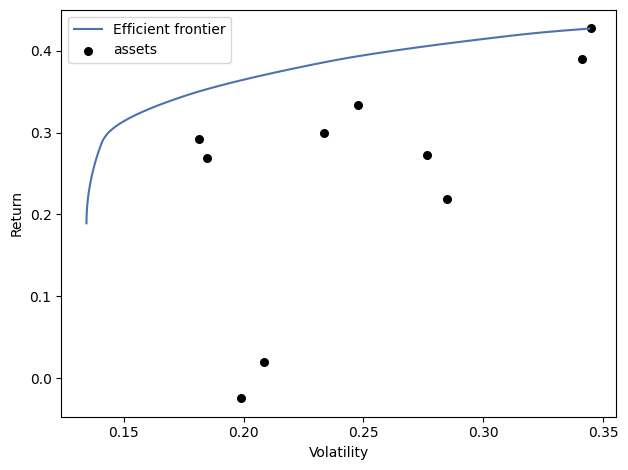

In [ ]:
mu = expected_returns.mean_historical_return(stocks_df[portfolio])
#Дисперсия портфеля
Sigma = risk_models.sample_cov(stocks_df[portfolio])
#Максимальный коэффициент Шарпа
ef = EfficientFrontier(mu, Sigma, weight_bounds=(0,1))

fig, ax = plt.subplots()
pplt.plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.show()

In [ ]:
ef = EfficientFrontier(mu, Sigma, weight_bounds=(0,1))

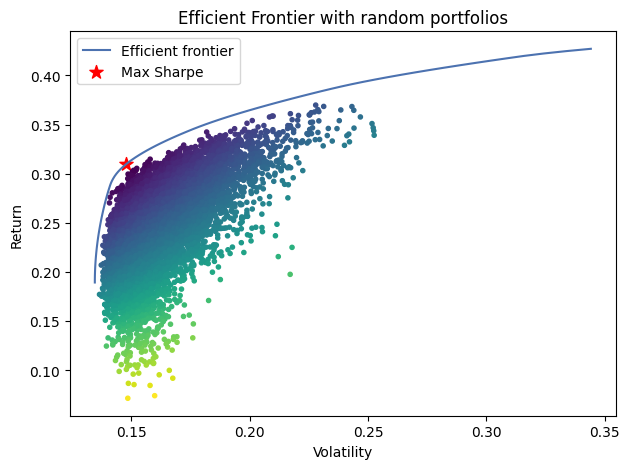

In [ ]:
fig, ax = plt.subplots()
ef_max_sharpe = copy.deepcopy(ef)
pplt.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

In [ ]:
stocks_df[portfolio]

,ABBV,APD,ANET,COST,GIS,HSY,MRK,MCK,PGR,SNPS
Date,,,,,,,,,,
2020-06-01,79.695244,226.643372,58.660000,294.449280,57.995144,129.359299,68.879494,155.529175,72.841507,182.600006
2020-06-02,79.993996,229.165817,57.612499,293.303131,57.885605,130.070435,69.987663,159.687988,73.529572,183.020004
2020-06-03,79.862198,232.117996,57.817501,292.873352,56.105774,127.263863,71.043892,158.249527,73.557465,184.210007
2020-06-04,81.751335,227.923279,57.165001,296.798798,55.457737,126.514771,70.602348,156.096756,73.269234,182.449997
2020-06-05,82.463058,232.230087,58.792500,298.030914,55.676788,128.420593,71.217041,158.151657,76.123741,182.970001
...,...,...,...,...,...,...,...,...,...,...
2021-05-25,105.754684,287.068024,84.574997,380.822357,59.299683,169.149109,69.262474,193.267151,95.186981,255.830002
2021-05-26,105.883926,283.587524,84.614998,381.059509,59.280815,168.742508,69.021156,191.571320,96.282890,254.279999
2021-05-27,103.686859,284.426697,84.279999,382.917236,58.761875,167.919617,67.850395,191.581177,97.016747,254.619995


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:10474: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


0.0796987552068784
0.05491426711264191


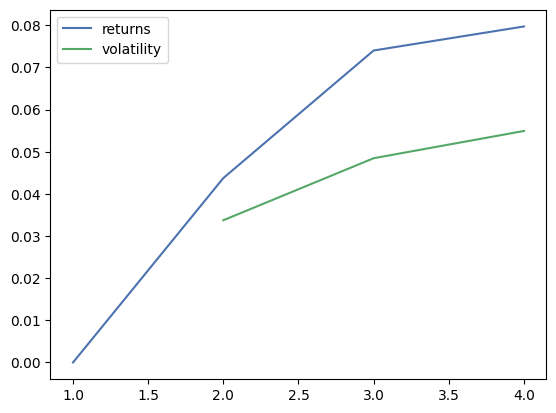

In [ ]:
iterate_over_period(df_stocks, portfolio, 20, '2021-03-01', '2021-06-01')

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:10474: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:10474: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide 

0.08175044964132228
0.05824509793480661


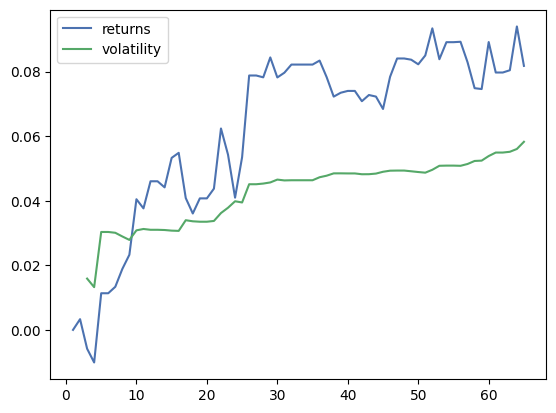

In [ ]:
iterate_over_period(df_stocks, portfolio, 1, '2021-03-01', '2021-06-01')

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:10474: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


0.08175044964132228
0.05824509793480661


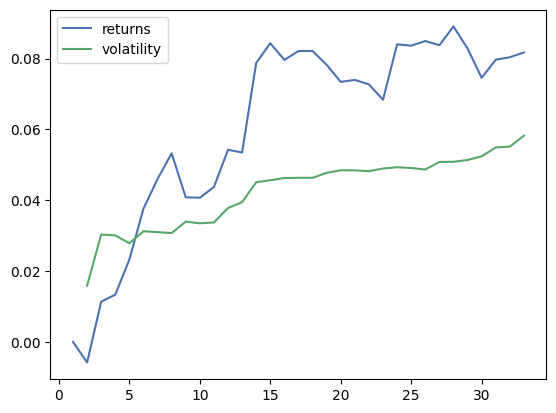

In [ ]:
iterate_over_period(df_stocks, portfolio, 2, '2021-03-01', '2021-06-01')

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:10474: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


0.0939541789545766
0.05602240189282889


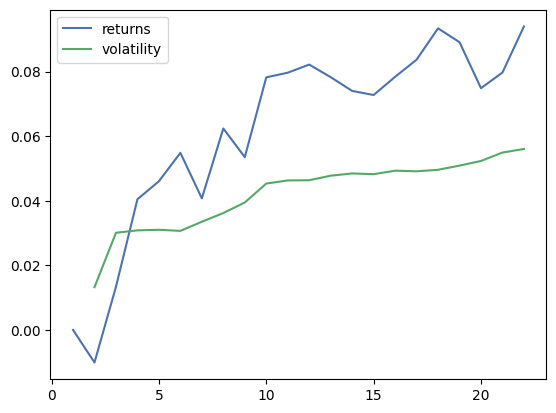

In [ ]:
iterate_over_period(df_stocks, portfolio, 3, '2021-03-01', '2021-06-01')

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:10474: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


0.08175044964132228
0.05824509793480661


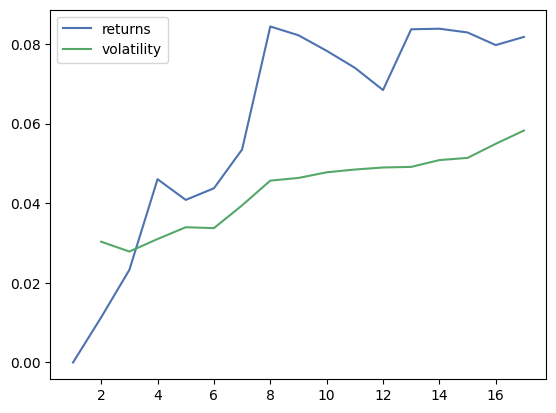

In [ ]:
iterate_over_period(df_stocks, portfolio, 4, '2021-03-01', '2021-06-01')

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:10474: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


0.0796987552068784
0.05491426711264191


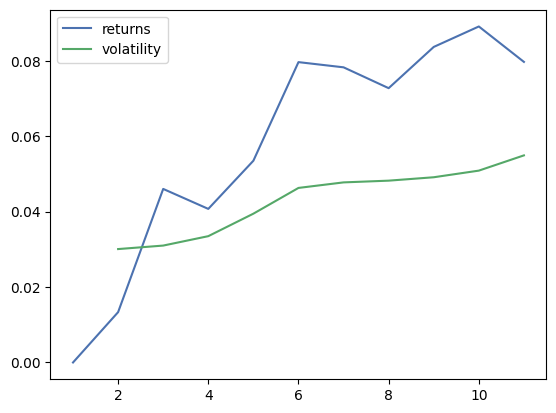

In [ ]:
iterate_over_period(df_stocks, portfolio, 6, '2021-03-01', '2021-06-01')

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:10474: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


0.0796987552068784
0.05491426711264191


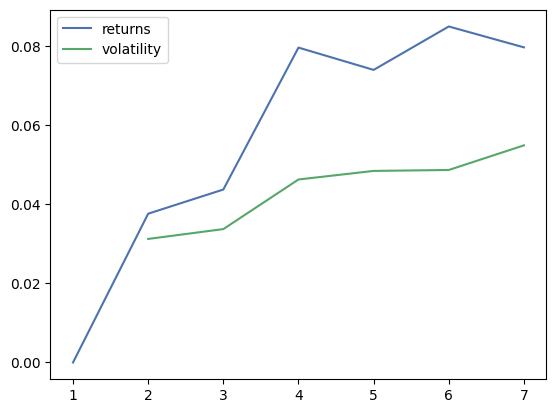

In [ ]:
iterate_over_period(df_stocks, portfolio, 10, '2021-03-01', '2021-06-01')

#### Complete linkage

##### Building a portfolio

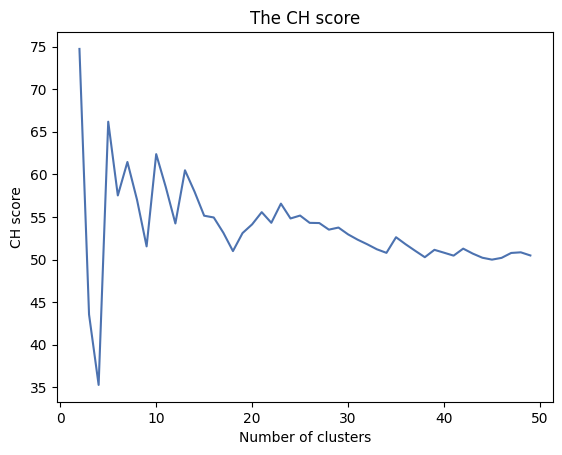

In [ ]:
calinski_harabasz_method(dissimilarity, 'complete')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 10, linkage='complete')
labels = clust.fit_predict(dissimilarity)

In [ ]:
calinski_harabasz_score(dissimilarity, labels) # 10

62.37853271764522

In [ ]:
cluster_dict = print_clusters(stocks_df, labels)

Cluster 3: A, ABBV, ACN, ADI, ADM, ADP, AIG, AJG, AMAT, ANET, AON, APH, ATVI, AVGO, AXP, AZO, BA, BAC, BKNG, BLK, BMY, BRK-B, C, CAT, CB, CDNS, CI, CMCSA, CME, CMG, COF, COP, CSCO, CSX, CTVA, CVS, CVX
Cluster 0: AAPL, ABT, ADBE, ADSK, AEP, AMD, AMGN, AMZN, APD
Cluster 5: AMT, BDX, BIIB
Cluster 7: BSX, CCI, CHTR, CL, COST, CRM, CTAS, DG
Cluster 2: D, DXCM, EQIX, GILD, GIS
Cluster 9: DE, DHR, DIS, DOW, DUK, ECL, EL, ELV, EMR, EOG, ETN, EW, EXC, F, FCX, FDX, FISV, FTNT, GD, GE, GM, GOOG, GOOGL, GS, HCA, HD, HES, HLT, HON, HSY, IBM, ICE, IDXX, INTU, ISRG, ITW, JCI, JNJ, JPM, KLAC
Cluster 1: HUM, INTC, KMB, LMT, MRK
Cluster 4: KO, LHX, LIN, LLY, LOW, LRCX, MA, MAR, MCD, MCHP, MCK, MCO, MDLZ, MDT, MET, META, MMC, MMM, MNST, MO, MPC, MRNA, MS, MSCI, MSFT, MSI, MU, NEE, NEM, NFLX, NKE, NOC, NOW, NSC, NUE, NVDA, NXPI, O, ORCL, ORLY, OXY, PEP, PFE, PG, PGR, PH, PLD, PM, PNC, PSA, PSX, PXD, PYPL, QCOM, ROP, RTX, SBUX, SCHW, SHW, SLB, SNPS, SO, SPGI, SRE, T
Cluster 8: REGN
Cluster 6: SYK, SYY, TDG

In [ ]:
portfolio2 = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio2

['AJG', 'AAPL', 'AMT', 'COST', 'GIS', 'DHR', 'LMT', 'SNPS', 'REGN', 'TGT']

In [ ]:
sharpe_pwt = optimize_portfolio(stocks_df, portfolio2, (0, 0.2))

OrderedDict([('AJG', 0.2), ('AAPL', 0.13776), ('AMT', 0.0), ('COST', 0.2), ('GIS', 0.02155), ('DHR', 0.2), ('LMT', 0.04069), ('SNPS', 0.0), ('REGN', 0.0), ('TGT', 0.2)])

Expected annual return: 53.1%
Annual volatility: 15.8%
Sharpe Ratio: 3.22


##### Checking stability

In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-06-01',
                    '2021-07-01',
                    portfolio2,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 5.3%
Annual volatility: 3.0%
Sharpe Ratio: 1.76
(0.05317710748113348, 0.030278653704994433, 1.7562573289829584)
Beta: 0.954404967896785
Cumulative return: 5.07%
Index stats
Expected return: 2.8%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-06-01',
                    '2021-08-01',
                    portfolio2,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 11.6%
Annual volatility: 4.2%
Sharpe Ratio: 2.75
(0.11561205992830301, 0.04210193909002644, 2.74600321094689)
Beta: 0.7238632577805351
Cumulative return: 11.27%
Index stats
Expected return: 4.6%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-06-01',
                    '2021-09-01',
                    portfolio2,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 15.5%
Annual volatility: 5.4%
Sharpe Ratio: 2.86
(0.15483085662430499, 0.05412837933110549, 2.860437695302096)
Beta: 0.8043485212141535
Cumulative return: 15.22%
Index stats
Expected return: 7.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-07-01',
                    '2021-08-01',
                    portfolio2,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 6.0%
Annual volatility: 3.1%
Sharpe Ratio: 1.96
(0.0600619301038355, 0.030647140260771415, 1.9597890567530458)
Beta: 0.6278307763867955
Cumulative return: 5.71%
Index stats
Expected return: 1.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-08-01',
                    '2021-09-01',
                    portfolio2,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 4.0%
Annual volatility: 3.5%
Sharpe Ratio: 1.16
(0.040275058752808894, 0.03471277000869436, 1.1602375362934554)
Beta: 1.0863552919046073
Cumulative return: 3.84%
Index stats
Expected return: 3.1%
Volatility: 0.0%


##### Extra

0.1403615963015291
0.05348405888520983


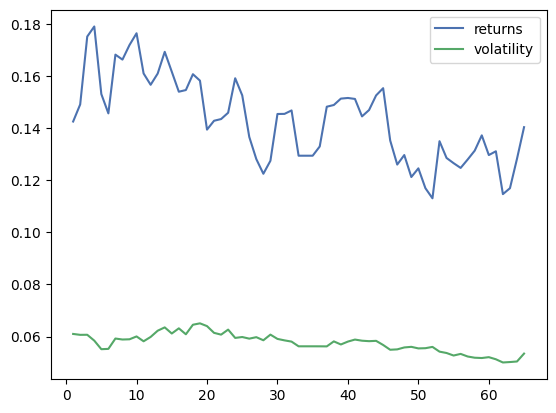

In [ ]:
iterate_over_period(df_stocks, portfolio2, 1, '2021-03-01', '2021-06-01')

0.1403615963015291
0.05348405888520983


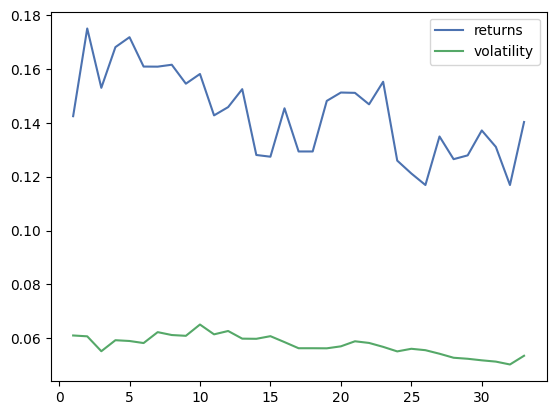

In [ ]:
iterate_over_period(df_stocks, portfolio2, 2, '2021-03-01', '2021-06-01')

0.12824979881927798
0.05045727391340776


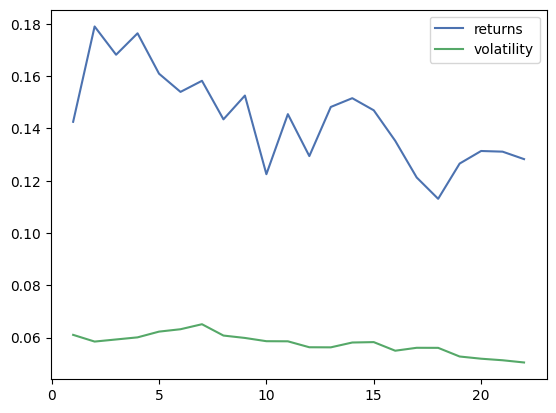

In [ ]:
iterate_over_period(df_stocks, portfolio2, 3, '2021-03-01', '2021-06-01')

0.1403615963015291
0.05348405888520983


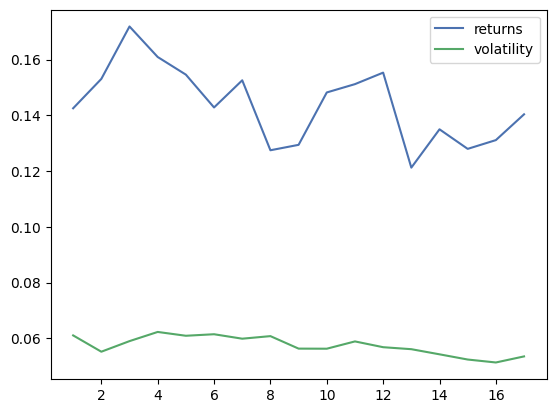

In [ ]:
iterate_over_period(df_stocks, portfolio2, 4, '2021-03-01', '2021-06-01')

0.13110631215713212
0.05130645410038014


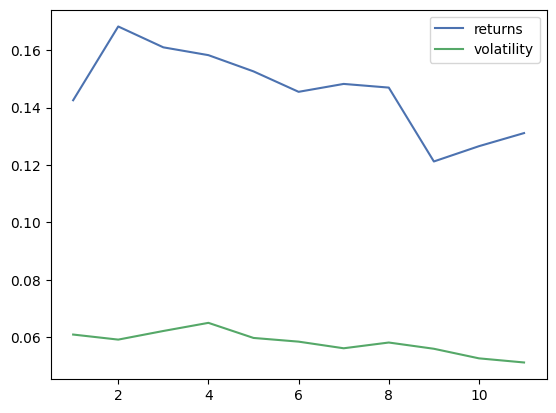

In [ ]:
iterate_over_period(df_stocks, portfolio2, 6, '2021-03-01', '2021-06-01')

0.13110631215713212
0.05130645410038014


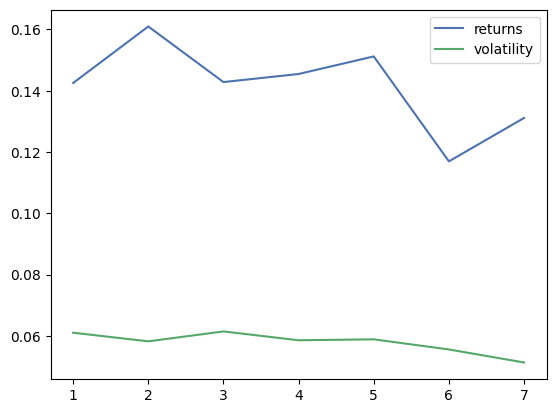

In [ ]:
iterate_over_period(df_stocks, portfolio2, 10, '2021-03-01', '2021-06-01')

0.13110631215713212
0.05130645410038014


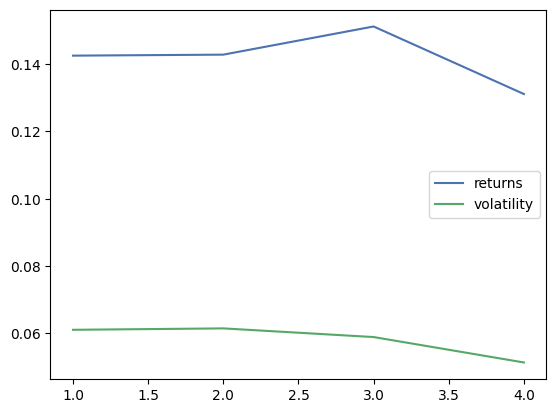

In [ ]:
iterate_over_period(df_stocks, portfolio2, 20, '2021-03-01', '2021-06-01')

#### Average Linkage

##### Building a portfolio

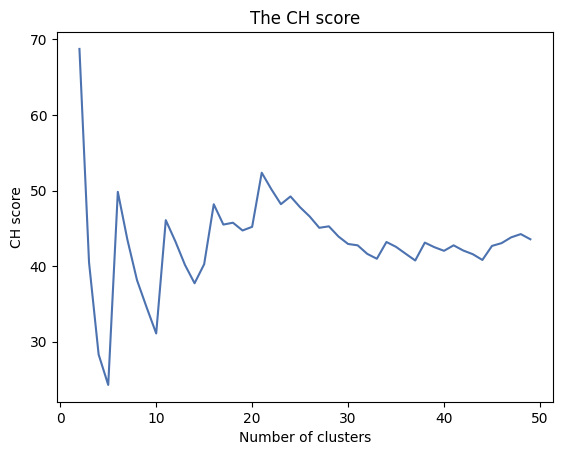

In [ ]:
calinski_harabasz_method(dissimilarity, 'average')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 21, linkage='average')
labels = clust.fit_predict(dissimilarity)

In [ ]:
calinski_harabasz_score(dissimilarity, labels)

52.3562594708405

In [ ]:
cluster_dict = print_clusters(stocks_df, labels)

Cluster 2: A, AAPL, ABBV, ABT, ACN, ADI, ADM, ADP, ADSK, AIG, AJG, AMAT, ANET, AON, APH, ATVI, AVGO, AXP, AZO, BA, BAC, BMY
Cluster 3: ADBE, AEP, AMD, AMGN, AMZN, APD
Cluster 12: AMT
Cluster 11: BDX, BIIB
Cluster 8: BKNG, BLK, BRK-B, C, CAT, CB, CI, CMCSA, CME, COF, COP, CSCO, CSX, CTVA, CVS, CVX, DE, DIS, DOW
Cluster 13: BSX, CCI
Cluster 18: CDNS, CHTR, CL, CMG, COST, CTAS
Cluster 6: CRM, DG
Cluster 16: D
Cluster 10: DHR, DUK, ECL, EW, FDX
Cluster 1: DXCM, EQIX
Cluster 20: EL, ELV, EMR, EOG, ETN, EXC, F, FCX, FISV, FTNT, GD, GE, GM, GOOG, GOOGL, GS, HCA, HD, HES, HLT, HON, HSY, IBM, ICE, IDXX, INTU, ISRG, ITW, JCI, JNJ, JPM, KLAC
Cluster 17: GILD, GIS
Cluster 0: HUM, INTC
Cluster 4: KMB, LMT
Cluster 14: KO, LHX, LIN, LLY, LOW, LRCX, MA, MAR, MCD, MCHP, MCK, MCO, MDLZ, MDT, MET, META, MMC, MMM, MNST, MO, MPC, MRNA, MS, MSCI, MSFT, MSI, MU
Cluster 19: MRK
Cluster 9: NEE, NEM, NFLX, NKE, NOC, NOW
Cluster 5: NSC, NUE, NVDA, NXPI, O, ORCL, ORLY, OXY, PEP, PFE, PG, PGR, PH, PLD, PM, PNC, PS

In [ ]:
portfolio3 = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio3

['AAPL',
 'AMZN',
 'AMT',
 'BDX',
 'DE',
 'CCI',
 'COST',
 'DG',
 'D',
 'DHR',
 'EQIX',
 'IDXX',
 'GIS',
 'HUM',
 'LMT',
 'MSFT',
 'MRK',
 'NEM',
 'NVDA',
 'REGN',
 'TGT']

In [ ]:
sharpe_pwt = optimize_portfolio(stocks_df, portfolio3, (0, 0.2))

OrderedDict([('AAPL', 0.0), ('AMZN', 0.0), ('AMT', 0.0), ('BDX', 0.0), ('DE', 0.2), ('CCI', 0.0), ('COST', 0.2), ('DG', 0.0), ('D', 0.0), ('DHR', 0.19153), ('EQIX', 0.0), ('IDXX', 0.16473), ('GIS', 0.02607), ('HUM', 0.0), ('LMT', 0.0), ('MSFT', 0.0), ('MRK', 0.0), ('NEM', 0.01767), ('NVDA', 0.0), ('REGN', 0.0), ('TGT', 0.2)])

Expected annual return: 76.0%
Annual volatility: 17.0%
Sharpe Ratio: 4.34


##### Checking stability

In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-06-01',
                    '2021-07-01',
                    portfolio3,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 6.5%
Annual volatility: 2.9%
Sharpe Ratio: 2.22
(0.06486228473359182, 0.029211335284442155, 2.2204491544806997)
Beta: 0.8024135032755545
Cumulative return: 6.19%
Index stats
Expected return: 2.8%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-06-01',
                    '2021-08-01',
                    portfolio3,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 13.5%
Annual volatility: 3.9%
Sharpe Ratio: 3.47
(0.13504668775965914, 0.038908164145591645, 3.470908759774011)
Beta: 0.6454713748623859
Cumulative return: 13.16%
Index stats
Expected return: 4.6%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-06-01',
                    '2021-09-01',
                    portfolio3,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 16.6%
Annual volatility: 5.3%
Sharpe Ratio: 3.14
(0.16613686589379786, 0.05297348753797953, 3.136226697830409)
Beta: 0.7460194500051442
Cumulative return: 16.33%
Index stats
Expected return: 7.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-07-01',
                    '2021-08-01',
                    portfolio3,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 6.8%
Annual volatility: 2.7%
Sharpe Ratio: 2.51
(0.06776887946746746, 0.027050528383445974, 2.5052700822265552)
Beta: 0.5867955721570066
Cumulative return: 6.44%
Index stats
Expected return: 1.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-08-01',
                    '2021-09-01',
                    portfolio3,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 3.6%
Annual volatility: 3.6%
Sharpe Ratio: 1.00
(0.035742835397572004, 0.035777832841801964, 0.9990218120704877)
Beta: 1.0760327048482539
Cumulative return: 3.41%
Index stats
Expected return: 3.1%
Volatility: 0.0%


##### Extra

0.20414355456886407
0.05704616176308251


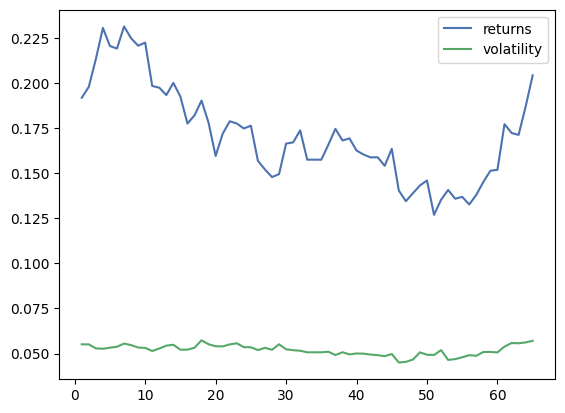

In [ ]:
iterate_over_period(df_stocks, portfolio3, 1, '2021-03-01', '2021-06-01')

0.20414355456886407
0.05704616176308251


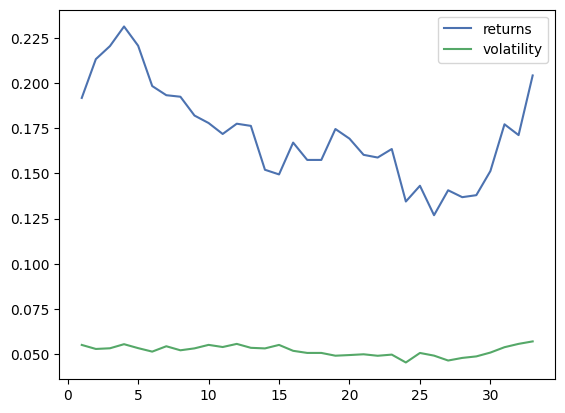

In [ ]:
iterate_over_period(df_stocks, portfolio3, 2, '2021-03-01', '2021-06-01')

0.18682155975389506
0.05614441367458281


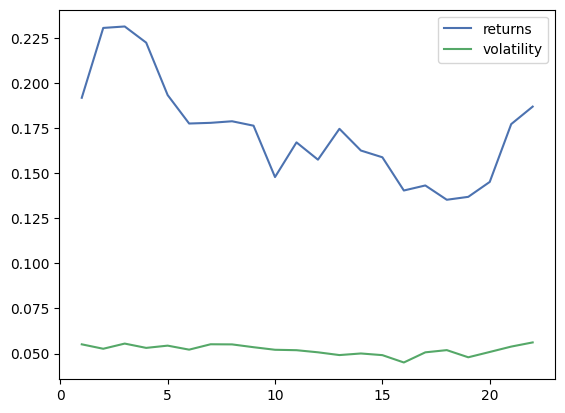

In [ ]:
iterate_over_period(df_stocks, portfolio3, 3, '2021-03-01', '2021-06-01')

0.20414355456886407
0.05704616176308251


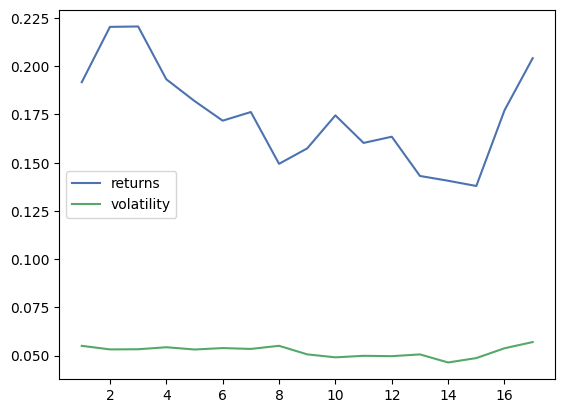

In [ ]:
iterate_over_period(df_stocks, portfolio3, 4, '2021-03-01', '2021-06-01')

0.17712421158374853
0.053833286057449435


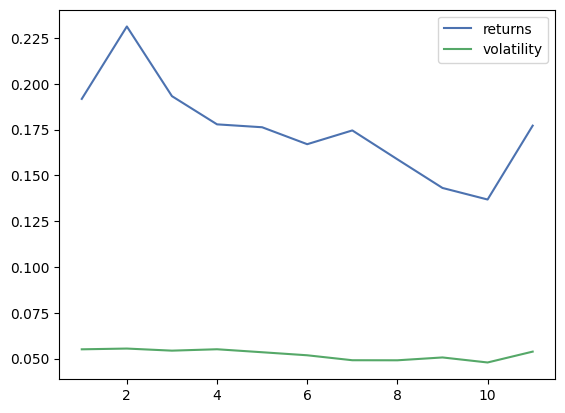

In [ ]:
iterate_over_period(df_stocks, portfolio3, 6, '2021-03-01', '2021-06-01')

0.17712421158374853
0.053833286057449435


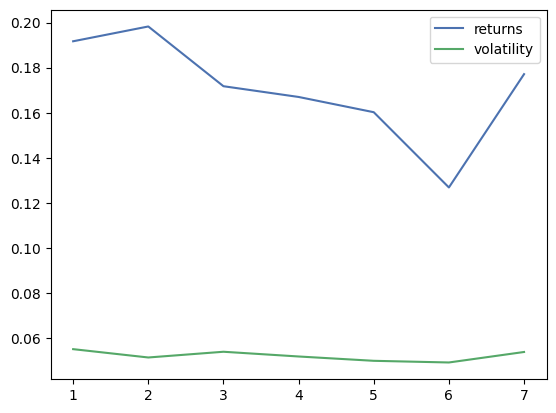

In [ ]:
iterate_over_period(df_stocks, portfolio3, 10, '2021-03-01', '2021-06-01')

0.17712421158374853
0.053833286057449435


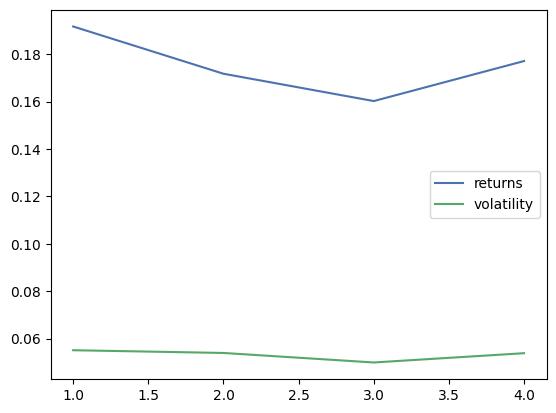

In [ ]:
iterate_over_period(df_stocks, portfolio3, 20, '2021-03-01', '2021-06-01')

0.17712421158374853
0.053833286057449435


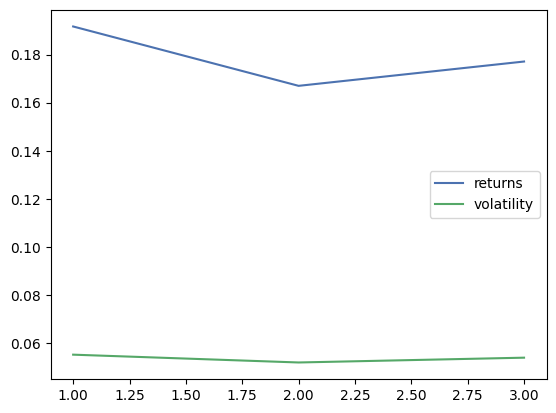

In [ ]:
iterate_over_period(df_stocks, portfolio3, 30, '2021-03-01', '2021-06-01')

#### Single Linkage

##### Building a portfolio

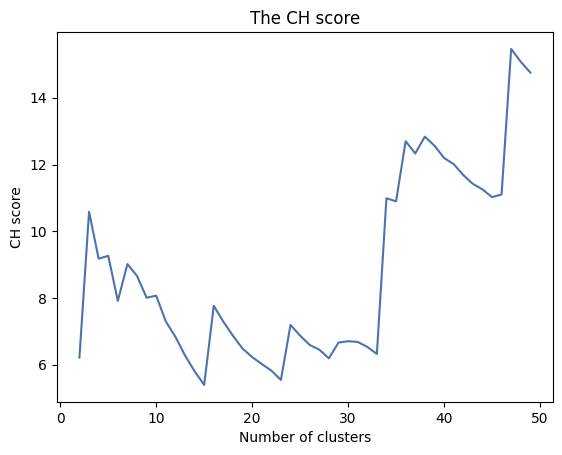

In [ ]:
calinski_harabasz_method(dissimilarity, 'single')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 48, linkage='average')
labels = clust.fit_predict(dissimilarity)

In [ ]:
calinski_harabasz_score(dissimilarity, labels) # 10

44.23660309335326

In [ ]:
cluster_dict = print_clusters(stocks_df, labels)

Cluster 4: A, ABBV, ACN, ADI, ADM, ADP, AIG, AJG, AMAT
Cluster 14: AAPL, ABT, ADSK
Cluster 36: ADBE
Cluster 31: AEP
Cluster 7: AMD, AMZN
Cluster 43: AMGN
Cluster 25: AMT
Cluster 3: ANET, AON, APH, ATVI, AVGO, AXP, BA, BAC
Cluster 26: APD
Cluster 0: AZO, BMY
Cluster 5: BDX, BIIB
Cluster 19: BKNG, BLK, BRK-B, C, CAT, CB, CI, CME
Cluster 27: BSX, CCI
Cluster 40: CDNS, CMG
Cluster 6: CHTR, CL, COST, CTAS
Cluster 9: CMCSA, COF, CSX, CTVA, DE, DIS, DOW
Cluster 13: COP, CSCO, CVS, CVX
Cluster 28: CRM
Cluster 33: D
Cluster 29: DG
Cluster 18: DHR, DUK
Cluster 45: DXCM
Cluster 35: ECL
Cluster 22: EL, ELV, EMR, ETN, EXC, F, FCX, FISV, GE
Cluster 1: EOG, FTNT, GD, HES
Cluster 47: EQIX
Cluster 42: EW, FDX
Cluster 8: GILD, GIS
Cluster 16: GM, GOOG, GOOGL, GS, HCA, HLT, HON, ICE, IDXX, INTU, ISRG, ITW, JCI, JNJ, JPM, KLAC
Cluster 23: HD, HSY, IBM
Cluster 44: HUM
Cluster 37: INTC
Cluster 12: KMB
Cluster 11: KO, LHX, LIN, LOW, MA, MCD, MCO, MDLZ, META, MMC
Cluster 30: LLY
Cluster 32: LMT
Cluster 10: LR

In [ ]:
portfolio4 = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
sharpe_pwt = optimize_portfolio(stocks_df, portfolio4, (0, 0.2))

OrderedDict([('AJG', 0.2), ('AAPL', 0.0), ('ADBE', 0.0), ('AEP', 0.0), ('AMZN', 0.0), ('AMGN', 0.0), ('AMT', 0.0), ('AON', 0.0), ('APD', 0.0), ('AZO', 0.0), ('BDX', 0.0), ('BLK', 0.04325), ('CCI', 0.0), ('CMG', 0.0), ('COST', 0.03702), ('DE', 0.2), ('CVS', 0.00052), ('CRM', 0.0), ('D', 0.0), ('DG', 0.0), ('DHR', 0.07067), ('DXCM', 0.0), ('ECL', 0.0), ('EL', 0.01753), ('FTNT', 0.0), ('EQIX', 0.0), ('EW', 0.0), ('GIS', 0.0), ('IDXX', 0.09591), ('HSY', 0.09593), ('HUM', 0.0), ('INTC', 0.0), ('KMB', 0.0), ('MMC', 0.0), ('LLY', 0.02511), ('LMT', 0.0), ('MSFT', 0.0), ('MRK', 0.0), ('NEE', 0.0), ('NEM', 0.0), ('NVDA', 0.00838), ('OXY', 0.00567), ('REGN', 0.0), ('ROP', 0.0), ('TGT', 0.2), ('SPGI', 0.0), ('VRTX', 0.0), ('ZTS', 0.0)])

Expected annual return: 80.3%
Annual volatility: 16.1%
Sharpe Ratio: 4.85


##### Checking stability

In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-06-01',
                    '2021-07-01',
                    portfolio4,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 3.7%
Annual volatility: 2.7%
Sharpe Ratio: 1.35
(0.0366245997009596, 0.02714992311639616, 1.3489761847186068)
Beta: 0.9094183165561197
Cumulative return: 3.49%
Index stats
Expected return: 2.8%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-06-01',
                    '2021-08-01',
                    portfolio4,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 7.6%
Annual volatility: 4.4%
Sharpe Ratio: 1.72
(0.0756097586004721, 0.043955317392431976, 1.7201504410815662)
Beta: 0.8944455319991658
Cumulative return: 7.37%
Index stats
Expected return: 4.6%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-06-01',
                    '2021-09-01',
                    portfolio4,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 9.7%
Annual volatility: 5.4%
Sharpe Ratio: 1.80
(0.09725360851138995, 0.05390431597186809, 1.8041896415519911)
Beta: 0.9289589461092126
Cumulative return: 9.56%
Index stats
Expected return: 7.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-07-01',
                    '2021-08-01',
                    portfolio4,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 3.8%
Annual volatility: 3.6%
Sharpe Ratio: 1.05
(0.03781431703142017, 0.035935439622805945, 1.0522848037573977)
Beta: 0.9244333513927376
Cumulative return: 3.59%
Index stats
Expected return: 1.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-08-01',
                    '2021-09-01',
                    portfolio4,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 2.9%
Annual volatility: 3.2%
Sharpe Ratio: 0.92
(0.02913973341478783, 0.03162664233157848, 0.9213666474386524)
Beta: 1.0673295375218508
Cumulative return: 2.78%
Index stats
Expected return: 3.1%
Volatility: 0.0%


##### Extra

0.18645308695133023
0.05691519979136658


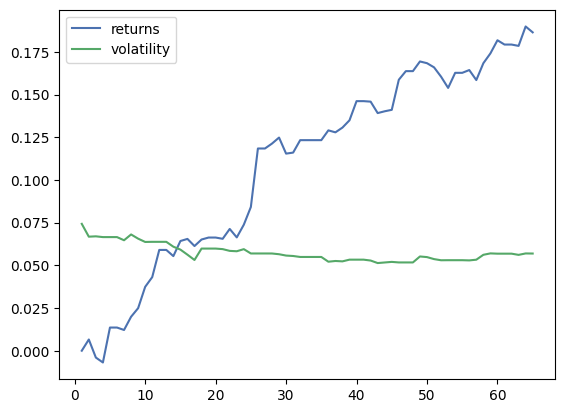

In [ ]:
iterate_over_period(df_stocks, portfolio4, (0, 0.2), 1, '2021-03-01', '2021-06-01')

0.40018511346182783
0.06111086428913276


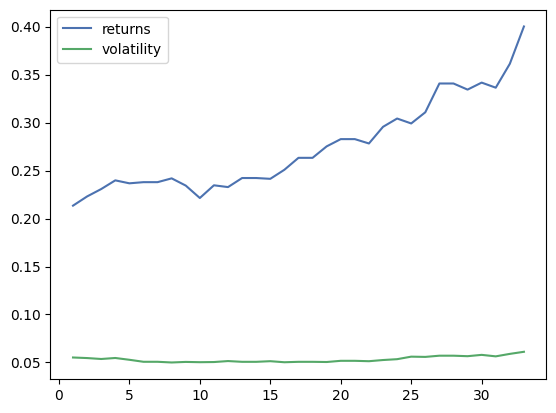

In [ ]:
iterate_over_period(df_stocks, portfolio4, 2, '2021-03-01', '2021-06-01')

0.39142296329225124
0.06043734643378408


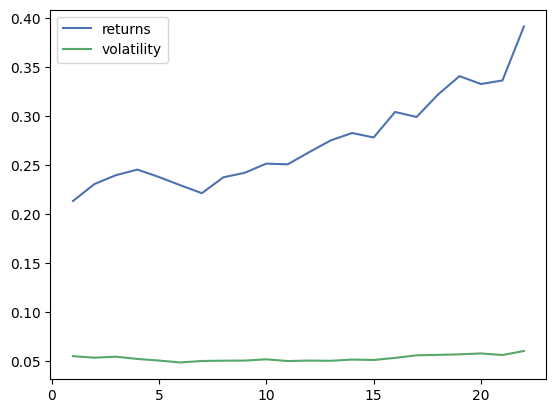

In [ ]:
iterate_over_period(df_stocks, portfolio4, 3, '2021-03-01', '2021-06-01')

0.40018511346182783
0.06111086428913276


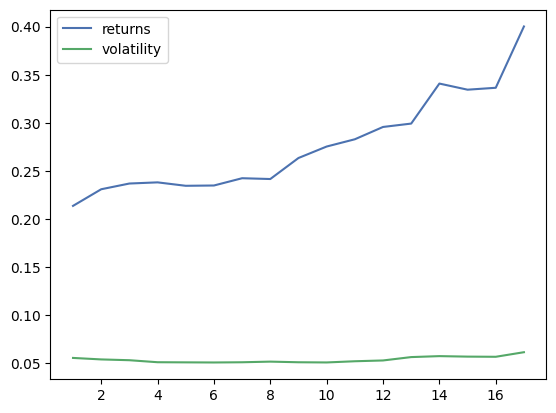

In [ ]:
iterate_over_period(df_stocks, portfolio4, 4, '2021-03-01', '2021-06-01')

0.3363754919371962
0.05634979712805679


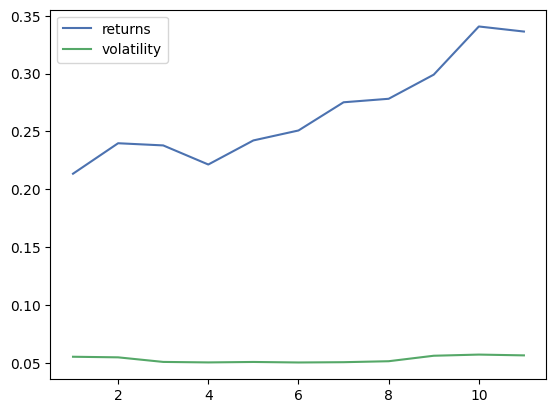

In [ ]:
iterate_over_period(df_stocks, portfolio4, 6, '2021-03-01', '2021-06-01')

0.3363754919371962
0.05634979712805679


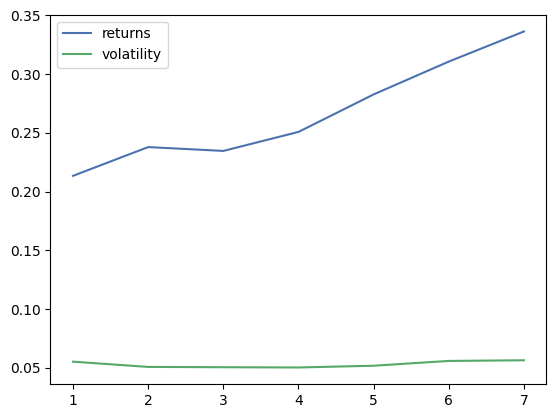

In [ ]:
iterate_over_period(df_stocks, portfolio4, 10, '2021-03-01', '2021-06-01')

0.3363754919371962
0.05634979712805679


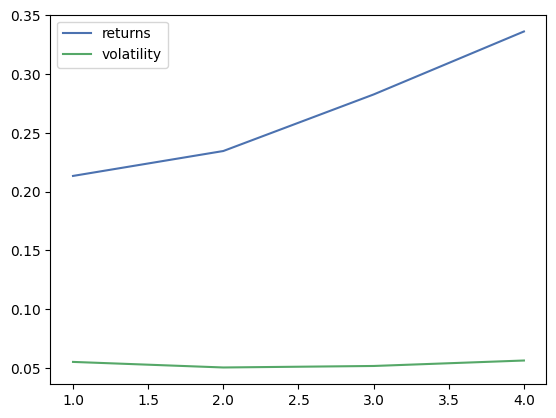

In [ ]:
iterate_over_period(df_stocks, portfolio4, 20, '2021-03-01', '2021-06-01')

0.3363754919371962
0.05634979712805679


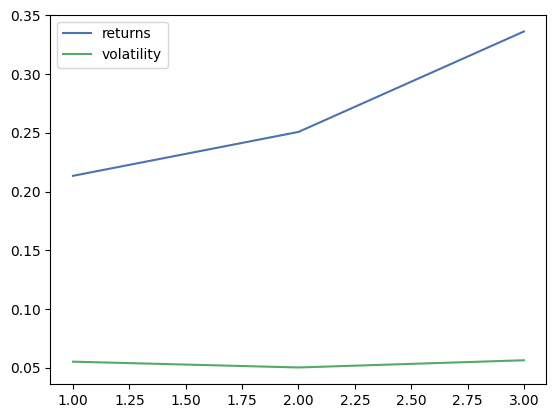

In [ ]:
iterate_over_period(df_stocks, portfolio4, 30, '2021-03-01', '2021-06-01')

### Multiplicators

In [ ]:
tickers = yf.Tickers(stock_tickers)

In [ ]:
tickers

yfinance.Tickers object <AAPL,MSFT,AMZN,NVDA,GOOGL,BRK-B,GOOG,TSLA,UNH,META,XOM,JNJ,JPM,V,PG,MA,CVX,HD,LLY,ABBV,MRK,AVGO,PEP,KO,PFE,TMO,COST,WMT,MCD,CSCO,BAC,CRM,DIS,ACN,ABT,LIN,ADBE,VZ,DHR,TXN,CMCSA,NEE,NKE,PM,AMD,NFLX,WFC,BMY,RTX,ORCL,UPS,T,QCOM,AMGN,INTC,COP,HON,INTU,LOW,UNP,SBUX,BA,IBM,ELV,CAT,PLD,SPGI,MS,GS,LMT,MDT,DE,GILD,GE,BLK,BKNG,AMAT,CVS,SYK,AMT,AXP,ADI,MDLZ,NOW,ISRG,C,TJX,ADP,TMUS,REGN,PGR,MMC,VRTX,PYPL,CB,MO,ZTS,CI,SCHW,SO,TGT,DUK,FISV,SLB,BSX,BDX,EOG,MU,CME,LRCX,NOC,HUM,AON,EQIX,ITW,CSX,CL,APD,ETN,WM,ATVI,MPC,ICE,FCX,CDNS,CCI,SNPS,MMM,HCA,EL,ORLY,FDX,SHW,VLO,KLAC,PXD,GIS,GD,MRNA,EW,F,MCK,PSA,PSX,USB,GM,PNC,DG,SRE,D,AEP,EMR,AZO,MSI,CMG,MCO,NSC,OXY,APH,ROP,KMB,ADM,TFC,NXPI,DXCM,MCHP,MAR,CTVA,FTNT,EXC,ADSK,MSCI,AJG,A,ECL,BIIB,PH,HES,TRV,TEL,MNST,SYY,NEM,IDXX,MET,ANET,DOW,TT,CTAS,O,JCI,XEL,TDG,HSY,AIG,LHX,HLT,CHTR,NUE,COF>

In [ ]:
# tickers.tickers['MSFT'].info

In [ ]:
indicators = pd.DataFrame(columns=['ticker', 'returnOnAssets',
                                   'revenueGrowth', 'ebitdaMargins'])
indicators

,ticker,returnOnAssets,revenueGrowth,ebitdaMargins


In [ ]:
for ticker in stock_tickers:
    try:
        indicators.loc[ticker] = [
            ticker,
            tickers.tickers[ticker].info['returnOnAssets'],
            tickers.tickers[ticker].info['revenueGrowth'],
            tickers.tickers[ticker].info['ebitdaMargins'],
        ]
    except KeyError:
        continue

    indicators = indicators.reset_index(drop=True)

In [ ]:
indicators.head()

,ticker,returnOnAssets,revenueGrowth,ebitdaMargins
0,AAPL,0.20559,-0.025,0.32145
1,MSFT,0.14829,0.071,0.48210
2,AMZN,0.01906,0.094,0.10896
3,NVDA,0.08166,-0.208,0.26399
4,GOOGL,0.12415,0.026,0.30742


In [ ]:
indicators.shape

(191, 4)

In [ ]:
tickers = indicators['ticker'].to_list()

In [ ]:
data = indicators.copy()
data = data.drop('ticker', axis=1)

#### Ward Linkage

##### Building a portfolio

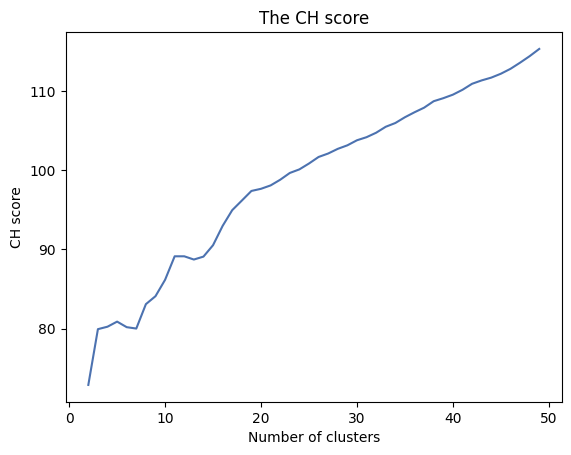

In [ ]:
calinski_harabasz_method(data, 'ward')

In [ ]:
model = AgglomerativeClustering(n_clusters = 15, linkage='ward')
labels = model.fit_predict(data)

In [ ]:
calinski_harabasz_score(data, labels)

90.5235191643985

In [ ]:
cluster_dict = print_clusters(stocks_df[tickers], labels)

Cluster 1: AAPL, XOM, CVX, LLY, ABBV, MRK, LIN, VZ, DHR, CMCSA, BMY, QCOM, AMGN, COP, GILD, BLK, TMUS, SO, LRCX, FCX, MCO, APH, BIIB, NEM, NUE
Cluster 0: MSFT, V, MA, AVGO, MCD, UNP, AMT, VRTX, MO, CME, CSX, ICE, CCI, PSA, MSCI, HES, O
Cluster 4: AMZN, UNH, HD, PEP, CRM, ACN, NKE, NFLX, RTX, LOW, SBUX, LMT, GE, MDLZ, TJX, CB, NOC, ETN, HCA, SHW, GIS, GD, GM, DG, CMG, KMB, DXCM, CTVA, ADSK, ECL, TRV, TEL, TT, JCI, LHX
Cluster 2: NVDA, TMO, ABT, AMD, UPS, INTC, MPC, MMM, EL, FDX, VLO, PSX, DOW, AIG, COF
Cluster 6: GOOGL, GOOG, JNJ, PG, KO, CSCO, HON, INTU, IBM, MDT, SYK, ISRG, ADP, MMC, BSX, BDX, AON, ITW, CL, WM, SNPS, ORLY, EMR, AZO, MSI, EXC, AJG, A, MNST, CTAS, XEL, HSY
Cluster 13: BRK-B, JPM, BA, NOW, PGR, F, USB
Cluster 11: TSLA, DE, SLB, ATVI, FTNT, PH
Cluster 14: META, ADBE, PM, T, AMAT, REGN, ZTS, CDNS, KLAC, EW, NSC, NXPI, IDXX, CHTR
Cluster 10: COST, WMT, BAC, WFC, ELV, MS, GS, CVS, AXP, C, CI, SCHW, TGT, HUM, MCK, PNC, ADM, TFC, SYY, MET
Cluster 12: TXN, EOG, PXD
Cluster 7: N

In [ ]:
portfolio5 = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio5

['DHR',
 'MSFT',
 'TT',
 'UPS',
 'SNPS',
 'PGR',
 'DE',
 'CHTR',
 'TGT',
 'TXN',
 'NEE',
 'EQIX',
 'PLD',
 'SRE',
 'MRNA']

In [ ]:
sharpe_pwt = optimize_portfolio(stocks_df, portfolio5, (0, 0.2))

OrderedDict([('DHR', 0.16042), ('MSFT', 0.2), ('TT', 0.15826), ('UPS', 0.1048), ('SNPS', 0.0), ('PGR', 0.02887), ('DE', 0.05811), ('CHTR', 0.0), ('TGT', 0.02502), ('TXN', 0.0), ('NEE', 0.0), ('EQIX', 0.0), ('PLD', 0.2), ('SRE', 0.0), ('MRNA', 0.06452)])

Expected annual return: 56.2%
Annual volatility: 14.5%
Sharpe Ratio: 3.73


##### Cheking stability

In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-06-01',
                    '2021-07-01',
                    portfolio5,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 5.7%
Annual volatility: 4.0%
Sharpe Ratio: 1.43
(0.05692605799309652, 0.03983686832180823, 1.4289792443833496)
Beta: 1.3476750363496717
Cumulative return: 5.43%
Index stats
Expected return: 2.8%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-06-01',
                    '2021-08-01',
                    portfolio5,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 14.8%
Annual volatility: 4.8%
Sharpe Ratio: 3.10
(0.1481594522597362, 0.04786141950827628, 3.0955925206964707)
Beta: 0.7967199928274937
Cumulative return: 14.4%
Index stats
Expected return: 4.6%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-06-01',
                    '2021-09-01',
                    portfolio5,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 21.0%
Annual volatility: 5.8%
Sharpe Ratio: 3.62
(0.21022135210194798, 0.05800921542198743, 3.6239302768136916)
Beta: 0.7834736224056619
Cumulative return: 20.63%
Index stats
Expected return: 7.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-07-01',
                    '2021-08-01',
                    portfolio5,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 8.2%
Annual volatility: 2.8%
Sharpe Ratio: 2.92
(0.0824128304883687, 0.028209417302379927, 2.9214651832392096)
Beta: 0.5278705402391254
Cumulative return: 7.8%
Index stats
Expected return: 1.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-08-01',
                    '2021-09-01',
                    portfolio5,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 5.7%
Annual volatility: 3.4%
Sharpe Ratio: 1.70
(0.057288973565163555, 0.033638735873468634, 1.7030655902366478)
Beta: 0.7692672251962925
Cumulative return: 5.47%
Index stats
Expected return: 3.1%
Volatility: 0.0%


#### Complete Linkage

##### Building a portfolio

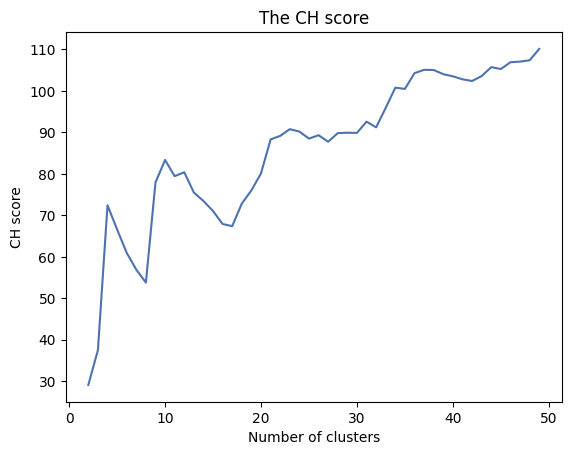

In [ ]:
calinski_harabasz_method(data, 'complete')

In [ ]:
model = AgglomerativeClustering(n_clusters = 12, linkage='complete')
labels = model.fit_predict(data)

In [ ]:
calinski_harabasz_score(data, labels)

80.38974469535066

In [ ]:
cluster_dict = print_clusters(stocks_df[tickers], labels)

Cluster 6: AAPL, LLY, ABBV, MRK, TXN, BMY, QCOM, AMGN, COP, GILD, BLK, EOG, LRCX, FCX, PXD, MCO, NEM, NUE
Cluster 1: MSFT, V, MA, AVGO, MCD, UNP, AMT, VRTX, MO, CME, CSX, ICE, CCI, KLAC, PSA, MSCI, HES
Cluster 3: AMZN, UNH, HD, PEP, COST, WMT, BAC, CRM, ACN, NKE, NFLX, WFC, RTX, UPS, LOW, ELV, MS, GS, LMT, GE, CVS, AXP, MDLZ, C, TJX, CB, CI, SCHW, TGT, NOC, HUM, ETN, MPC, HCA, FDX, SHW, VLO, GIS, GD, MCK, PSX, GM, PNC, DG, KMB, ADM, TFC, DXCM, CTVA, ADSK, ECL, TRV, TEL, SYY, MET, TT, JCI, LHX
Cluster 2: NVDA, ABT, INTC, DOW, AIG, COF
Cluster 5: GOOGL, GOOG, XOM, PG, CVX, TMO, LIN, VZ, DHR, CMCSA, AMD, HON, IBM, MDT, TMUS, MMC, SO, BDX, ITW, WM, SNPS, MMM, EL, APH, BIIB
Cluster 9: BRK-B, TSLA, JPM, BA, DE, NOW, PGR, SLB, ATVI, F, USB, FTNT, PH
Cluster 8: META, JNJ, KO, CSCO, ADBE, PM, ORCL, T, INTU, SBUX, AMAT, SYK, ISRG, ADP, REGN, ZTS, FISV, BSX, AON, EQIX, CL, CDNS, ORLY, EW, EMR, AZO, MSI, CMG, NSC, ROP, NXPI, EXC, AJG, A, MNST, IDXX, CTAS, XEL, HSY, CHTR
Cluster 7: NEE
Cluster 4: P

In [ ]:
portfolio6 = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio6

['AAPL',
 'MSFT',
 'TGT',
 'NVDA',
 'DHR',
 'DE',
 'CHTR',
 'NEE',
 'PLD',
 'SRE',
 'MRNA',
 'O']

In [ ]:
sharpe_pwt = optimize_portfolio(stocks_df, portfolio6, (0, 0.2))

OrderedDict([('AAPL', 0.0), ('MSFT', 0.2), ('TGT', 0.0), ('NVDA', 0.12993), ('DHR', 0.14295), ('DE', 0.0933), ('CHTR', 0.0), ('NEE', 0.0), ('PLD', 0.2), ('SRE', 0.0), ('MRNA', 0.0586), ('O', 0.17522)])

Expected annual return: 65.5%
Annual volatility: 16.2%
Sharpe Ratio: 3.92


##### Cheking stability

In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-06-01',
                    '2021-07-01',
                    portfolio6,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 8.0%
Annual volatility: 3.9%
Sharpe Ratio: 2.07
(0.08047610719997253, 0.03890548342383545, 2.0685029491413243)
Beta: 1.1384970709624116
Cumulative return: 7.66%
Index stats
Expected return: 2.8%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-06-01',
                    '2021-08-01',
                    portfolio6,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 16.3%
Annual volatility: 4.5%
Sharpe Ratio: 3.59
(0.1627009479389682, 0.04538100599864888, 3.5852212695287595)
Beta: 0.6966821970802514
Cumulative return: 15.83%
Index stats
Expected return: 4.6%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-06-01',
                    '2021-09-01',
                    portfolio6,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 25.6%
Annual volatility: 5.8%
Sharpe Ratio: 4.44
(0.2559289218662605, 0.05758021341684981, 4.444737292192243)
Beta: 0.750414215861714
Cumulative return: 25.13%
Index stats
Expected return: 7.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-07-01',
                    '2021-08-01',
                    portfolio6,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 7.7%
Annual volatility: 2.5%
Sharpe Ratio: 3.02
(0.07651924691547002, 0.0253514667363941, 3.018336087261586)
Beta: 0.4802000315272544
Cumulative return: 7.25%
Index stats
Expected return: 1.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-08-01',
                    '2021-09-01',
                    portfolio6,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 8.3%
Annual volatility: 3.7%
Sharpe Ratio: 2.25
(0.08264247521375731, 0.03664897350441023, 2.2549738044862937)
Beta: 0.9449604159806801
Cumulative return: 7.89%
Index stats
Expected return: 3.1%
Volatility: 0.0%


#### Average Linkage

##### Building a portfolio

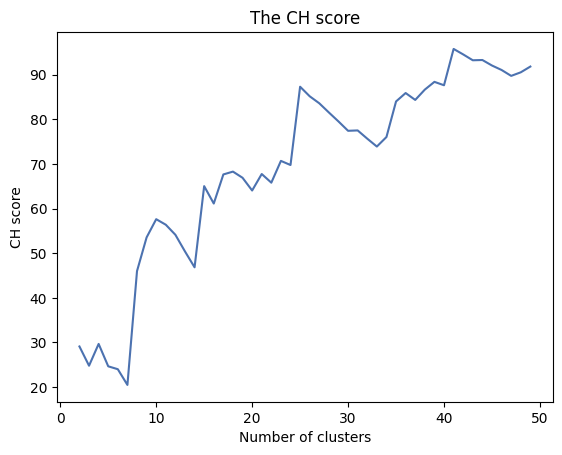

In [ ]:
calinski_harabasz_method(data, 'average')

In [ ]:
model = AgglomerativeClustering(n_clusters = 14, linkage='average')
labels = model.fit_predict(data)

In [ ]:
calinski_harabasz_score(data, labels)

46.83163119409036

In [ ]:
cluster_dict = print_clusters(stocks_df[tickers], labels)

Cluster 5: AAPL, MSFT, META, LLY, ABBV, MRK, MCD, LIN, VZ, DHR, CMCSA, PM, BMY, T, QCOM, AMGN, COP, UNP, GILD, BLK, TMUS, REGN, ZTS, SO, LRCX, CSX, FCX, KLAC, MCO, NSC, NXPI, BIIB, HES, NEM, CHTR, NUE
Cluster 0: AMZN, GOOGL, BRK-B, GOOG, UNH, XOM, JNJ, JPM, PG, CVX, HD, PEP, KO, TMO, COST, WMT, CSCO, BAC, CRM, ACN, ADBE, NKE, AMD, NFLX, WFC, RTX, UPS, HON, INTU, LOW, SBUX, BA, IBM, ELV, MS, GS, LMT, MDT, GE, AMAT, CVS, SYK, AXP, MDLZ, NOW, ISRG, C, TJX, ADP, PGR, MMC, CB, CI, SCHW, TGT, BSX, BDX, NOC, HUM, AON, ITW, CL, ETN, WM, MPC, CDNS, SNPS, MMM, HCA, EL, ORLY, FDX, SHW, VLO, GIS, GD, EW, F, MCK, PSX, USB, GM, PNC, DG, EMR, AZO, MSI, CMG, APH, KMB, ADM, TFC, DXCM, CTVA, EXC, ADSK, AJG, A, ECL, TRV, TEL, MNST, SYY, IDXX, MET, TT, CTAS, JCI, XEL, HSY, LHX
Cluster 3: NVDA, ABT, INTC, DOW, AIG
Cluster 4: TSLA, DE, BKNG, SLB, ATVI, FTNT, PH
Cluster 1: V, MA, AVGO, AMT, VRTX, MO, CME, ICE, CCI, PSA, MSCI
Cluster 11: TXN, EOG, PXD
Cluster 7: NEE
Cluster 8: ORCL, SPGI, ADI, FISV, EQIX, D, 

In [ ]:
portfolio7 = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio7

['DHR',
 'TGT',
 'NVDA',
 'DE',
 'MSCI',
 'TXN',
 'NEE',
 'EQIX',
 'PLD',
 'MRNA',
 'SRE',
 'ANET',
 'O',
 'COF']

In [ ]:
sharpe_pwt = optimize_portfolio(stocks_df, portfolio7, (0, 0.2))

OrderedDict([('DHR', 0.14853), ('TGT', 0.0), ('NVDA', 0.10514), ('DE', 0.0), ('MSCI', 0.0), ('TXN', 0.0), ('NEE', 0.0), ('EQIX', 0.0), ('PLD', 0.2), ('MRNA', 0.05511), ('SRE', 0.0), ('ANET', 0.19573), ('O', 0.09631), ('COF', 0.19917)])

Expected annual return: 76.5%
Annual volatility: 16.6%
Sharpe Ratio: 4.48


##### Cheking stability

In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-06-01',
                    '2021-07-01',
                    portfolio7,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 6.4%
Annual volatility: 3.6%
Sharpe Ratio: 1.77
(0.06434438611208389, 0.036317376530754245, 1.771724509274392)
Beta: 1.2141849963546014
Cumulative return: 6.12%
Index stats
Expected return: 2.8%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-06-01',
                    '2021-08-01',
                    portfolio7,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 14.5%
Annual volatility: 4.9%
Sharpe Ratio: 2.97
(0.1450577829797526, 0.04880522771028471, 2.972177157759365)
Beta: 0.8337609877075516
Cumulative return: 14.11%
Index stats
Expected return: 4.6%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-06-01',
                    '2021-09-01',
                    portfolio7,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 20.2%
Annual volatility: 5.8%
Sharpe Ratio: 3.49
(0.2018407349329049, 0.05786733270411535, 3.487990987332143)
Beta: 0.832474258798036
Cumulative return: 19.81%
Index stats
Expected return: 7.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-07-01',
                    '2021-08-01',
                    portfolio7,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 7.5%
Annual volatility: 3.4%
Sharpe Ratio: 2.20
(0.07517430121790296, 0.03424584232468006, 2.1951365805281084)
Beta: 0.6595976307591068
Cumulative return: 7.12%
Index stats
Expected return: 1.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-08-01',
                    '2021-09-01',
                    portfolio7,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 5.1%
Annual volatility: 3.2%
Sharpe Ratio: 1.61
(0.05148100022468836, 0.03194761969952775, 1.6114189635683358)
Beta: 0.8641939854486448
Cumulative return: 4.91%
Index stats
Expected return: 3.1%
Volatility: 0.0%


#### Single Linkage

##### Building a portfolio

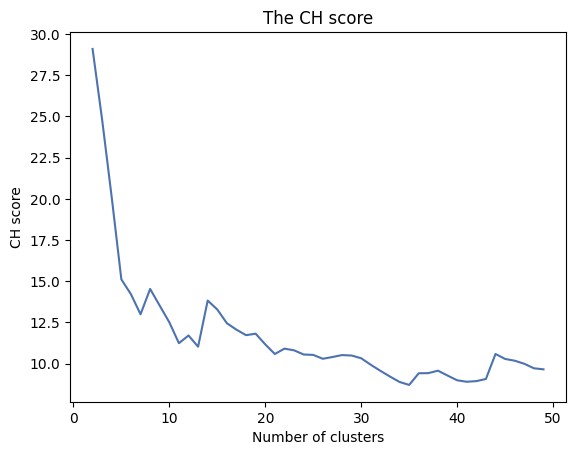

In [ ]:
calinski_harabasz_method(data, 'single')

In [ ]:
model = AgglomerativeClustering(n_clusters = 10, linkage='single')
labels = model.fit_predict(data)

In [ ]:
calinski_harabasz_score(data, labels)

12.512584828722687

In [ ]:
cluster_dict = print_clusters(stocks_df[tickers], labels)

Cluster 1: AAPL, MSFT, AMZN, NVDA, GOOGL, BRK-B, GOOG, TSLA, UNH, META, XOM, JNJ, JPM, V, PG, MA, CVX, HD, LLY, ABBV, MRK, AVGO, PEP, KO, TMO, COST, WMT, MCD, CSCO, BAC, CRM, ACN, ABT, LIN, ADBE, VZ, DHR, TXN, CMCSA, NKE, PM, AMD, NFLX, WFC, BMY, RTX, ORCL, UPS, T, QCOM, AMGN, COP, HON, INTU, LOW, UNP, SBUX, BA, IBM, ELV, SPGI, MS, GS, LMT, MDT, DE, GILD, GE, BLK, BKNG, AMAT, CVS, SYK, AMT, AXP, ADI, MDLZ, NOW, ISRG, C, TJX, ADP, TMUS, REGN, PGR, MMC, VRTX, CB, MO, ZTS, CI, SCHW, SO, TGT, FISV, SLB, BSX, BDX, EOG, CME, LRCX, NOC, HUM, AON, EQIX, ITW, CSX, CL, ETN, WM, ATVI, MPC, ICE, FCX, CDNS, CCI, SNPS, MMM, HCA, EL, ORLY, FDX, SHW, VLO, KLAC, PXD, GIS, GD, EW, F, MCK, PSA, PSX, USB, GM, PNC, DG, D, EMR, AZO, MSI, CMG, MCO, NSC, APH, ROP, KMB, ADM, TFC, NXPI, DXCM, MCHP, CTVA, FTNT, EXC, ADSK, MSCI, AJG, A, ECL, BIIB, PH, HES, TRV, TEL, MNST, SYY, NEM, IDXX, MET, DOW, TT, CTAS, JCI, XEL, HSY, AIG, LHX, CHTR, NUE
Cluster 7: NEE
Cluster 8: INTC
Cluster 0: PLD, MAR, HLT
Cluster 9: MU
Cl

In [ ]:
portfolio8 = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio8

['TGT', 'NEE', 'INTC', 'PLD', 'MU', 'MRNA', 'SRE', 'ANET', 'O', 'COF']

In [ ]:
sharpe_pwt = optimize_portfolio(stocks_df, portfolio8, (0, 0.2))

OrderedDict([('TGT', 0.03253), ('NEE', 0.08839), ('INTC', 0.0), ('PLD', 0.2), ('MU', 0.0), ('MRNA', 0.07908), ('SRE', 0.0), ('ANET', 0.2), ('O', 0.2), ('COF', 0.2)])

Expected annual return: 66.3%
Annual volatility: 15.6%
Sharpe Ratio: 4.12


##### Cheking stability

In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-06-01',
                    '2021-07-01',
                    portfolio8,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 2.9%
Annual volatility: 4.2%
Sharpe Ratio: 0.70
(0.029296320943004626, 0.04192300255097091, 0.6988125649489326)
Beta: 1.3482289139978973
Cumulative return: 2.78%
Index stats
Expected return: 2.8%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-06-01',
                    '2021-08-01',
                    portfolio8,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 12.9%
Annual volatility: 5.3%
Sharpe Ratio: 2.44
(0.12854343583971511, 0.05265830908118642, 2.441085520644655)
Beta: 0.8639952623622741
Cumulative return: 12.49%
Index stats
Expected return: 4.6%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-06-01',
                    '2021-09-01',
                    portfolio8,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 16.3%
Annual volatility: 6.1%
Sharpe Ratio: 2.66
(0.16334614036130835, 0.061369551522407105, 2.661680529010674)
Beta: 0.7832325030496488
Cumulative return: 16.02%
Index stats
Expected return: 7.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-07-01',
                    '2021-08-01',
                    portfolio8,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 9.0%
Annual volatility: 3.3%
Sharpe Ratio: 2.78
(0.09037829268504298, 0.03254627921285981, 2.776916282624785)
Beta: 0.6411953912602602
Cumulative return: 8.56%
Index stats
Expected return: 1.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2021-08-01',
                    '2021-09-01',
                    portfolio8,
                    sharpe_pwt)

Portfolio stats
Expected annual return: 3.4%
Annual volatility: 3.2%
Sharpe Ratio: 1.07
(0.03439702467213627, 0.03216309770659497, 1.069456213015304)
Beta: 0.5606269547039601
Cumulative return: 3.28%
Index stats
Expected return: 3.1%
Volatility: 0.0%


### Drawdowns

In [ ]:
# https://drive.google.com/file/d/1A0xXx8KnFmtBn7pcjK1nff7PP5jDiWBl/view?usp=share_link

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1A0xXx8KnFmtBn7pcjK1nff7PP5jDiWBl' -O drawdowns-2020.csv

--2023-05-13 22:45:57--  https://docs.google.com/uc?export=download&id=1A0xXx8KnFmtBn7pcjK1nff7PP5jDiWBl
Resolving docs.google.com (docs.google.com)... 142.251.107.113, 142.251.107.138, 142.251.107.139, ...
Connecting to docs.google.com (docs.google.com)|142.251.107.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/dcp0aklsro0990aehhc5vvnbc53pbaho/1684017900000/11915959673283641640/*/1A0xXx8KnFmtBn7pcjK1nff7PP5jDiWBl?e=download&uuid=4a339c85-8c92-47fa-89d6-ccf6c2b21015 [following]
--2023-05-13 22:45:57--  https://doc-0c-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/dcp0aklsro0990aehhc5vvnbc53pbaho/1684017900000/11915959673283641640/*/1A0xXx8KnFmtBn7pcjK1nff7PP5jDiWBl?e=download&uuid=4a339c85-8c92-47fa-89d6-ccf6c2b21015
Resolving doc-0c-60-docs.googleusercontent.com (doc-0c-60-docs.googleusercontent.com)... 173.194.212.132, 2607:

In [ ]:
drawdowns_2020 = pd.read_csv('drawdowns-2020.csv',
                             sep=';',
                             decimal=',',
                             index_col=0,
                             header=0,
                             names=['Ticker',
                                    'return',
                                    'risk',
                                    'cum_drawdown',
                                    'max_drawdown'])
drawdowns_2020

,Ticker,return,risk,cum_drawdown,max_drawdown
1,AAPL,0.591955,0.029405,14.764558,58.965542
2,MSFT,0.343873,0.027716,14.901497,41.541118
3,ATVI,0.446354,0.024419,17.671408,43.941842
4,EA,0.289448,0.022881,24.337867,40.837019
5,HPQ,0.179479,0.034794,36.158227,46.685645
...,...,...,...,...,...
63,COP,-0.486219,0.046097,66.543214,65.899519
64,CVX,-0.355573,0.038922,69.627463,55.348761
65,EOG,-0.518536,0.048654,65.799384,66.670400
66,SLB,-0.610582,0.049686,55.099437,70.480157


In [ ]:
drawdowns_2020.isna().sum().sum()

0

In [ ]:
drawdowns_2020.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67 entries, 1 to 67
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Ticker        67 non-null     object 
 1   return        67 non-null     float64
 2   risk          67 non-null     float64
 3   cum_drawdown  67 non-null     float64
 4   max_drawdown  67 non-null     float64
dtypes: float64(4), object(1)
memory usage: 3.1+ KB


In [ ]:
tickers = drawdowns_2020['Ticker'].to_list()

In [ ]:
drawdowns_df = yf.download(tickers,
                           start='2019-01-01',
                           end='2023-04-01')['Adj Close']

[*********************100%***********************]  67 of 67 completed


In [ ]:
drawdowns_df.isna().sum().sum()

0

In [ ]:
drawdowns_df.index = pd.to_datetime(drawdowns_df.index)

In [ ]:
drawdowns_df_cut = get_df_between_dates(drawdowns_df,
                                        '2020-06-01',
                                        '2021-06-01')

In [ ]:
returns = get_sharpe_ratio_info(get_df_between_dates(drawdowns_df,
                                                     '2019-01-01',
                                                     '2021-06-01'))

In [ ]:
scaler = StandardScaler()
data = scaler.fit_transform(drawdowns_2020.drop('Ticker', axis=1))

#### Ward Linkage

##### Building a portfolio

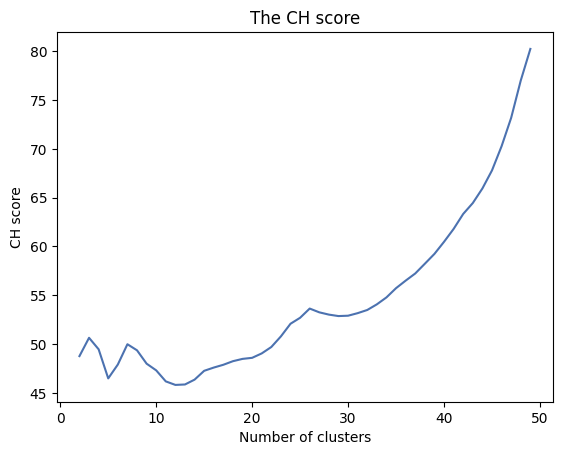

In [ ]:
calinski_harabasz_method(data, 'ward')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 8, linkage='ward')
labels = clust.fit_predict(data)

In [ ]:
calinski_harabasz_score(data, labels)

49.35888795010615

In [ ]:
cluster_dict = print_clusters(drawdowns_df_cut, labels)

Cluster 4: AAPL, AZN, BK, COST, EA, EQIX, F, JNJ
Cluster 0: ABBV, ADBE, ADSK, BIIB, BKNG, BLK, C, COP, CVX, GILD, M, MA, MS, MSFT, QCOM, STX
Cluster 5: AMGN, ATVI, BAC, EOG, IBM, INCY, INTC, JWN, LLY
Cluster 1: AMZN, AVGO, CCI, LUMN, META, NVDA, ORCL, PSA, REGN, SCHW, SLB, SPG, STT, T, UNH
Cluster 2: EBAY, PFE, PLD, TXN
Cluster 7: GM, GS, IT, JPM, V
Cluster 6: GOOG, HPQ, VZ, XOM
Cluster 3: MRK, MU, NFLX, VRTX, WFC, WMT


In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio

['COST', 'MSFT', 'ATVI', 'NVDA', 'EBAY', 'GS', 'GOOG', 'WMT']

In [ ]:
weights = optimize_portfolio(drawdowns_df_cut, portfolio, (0, 0.2))

OrderedDict([('COST', 0.2), ('MSFT', 0.0), ('ATVI', 0.0496), ('NVDA', 0.13716), ('EBAY', 0.09405), ('GS', 0.2), ('GOOG', 0.2), ('WMT', 0.11919)])

Expected annual return: 57.0%
Annual volatility: 18.7%
Sharpe Ratio: 2.94


##### Cheking stability

In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2021-06-01',
                    '2021-07-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 5.8%
Annual volatility: 3.4%
Sharpe Ratio: 1.72
(0.05849280408186623, 0.03393766809655409, 1.7235363347726707)
Beta: 1.0837055962142461
Cumulative return: 5.57%
Index stats
Expected return: 2.8%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2021-06-01',
                    '2021-08-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 8.0%
Annual volatility: 4.9%
Sharpe Ratio: 1.64
(0.08027645685325481, 0.04906337271963716, 1.6361789335596348)
Beta: 0.991747072983557
Cumulative return: 7.83%
Index stats
Expected return: 4.6%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2021-06-01',
                    '2021-09-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 17.6%
Annual volatility: 5.8%
Sharpe Ratio: 3.04
(0.17571406965496494, 0.057767687528947745, 3.0417362572617006)
Beta: 1.008335197293616
Cumulative return: 17.27%
Index stats
Expected return: 7.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2021-07-01',
                    '2021-08-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 2.4%
Annual volatility: 3.7%
Sharpe Ratio: 0.65
(0.0237704771674518, 0.036830365299147294, 0.6454043280423868)
Beta: 0.9769966419332679
Cumulative return: 2.26%
Index stats
Expected return: 1.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2021-08-01',
                    '2021-09-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 8.5%
Annual volatility: 3.1%
Sharpe Ratio: 2.73
(0.08515842297343806, 0.03122595393405511, 2.7271680203359314)
Beta: 1.1318154530940414
Cumulative return: 8.13%
Index stats
Expected return: 3.1%
Volatility: 0.0%


#### Complete Linkage

##### Building a portfolio

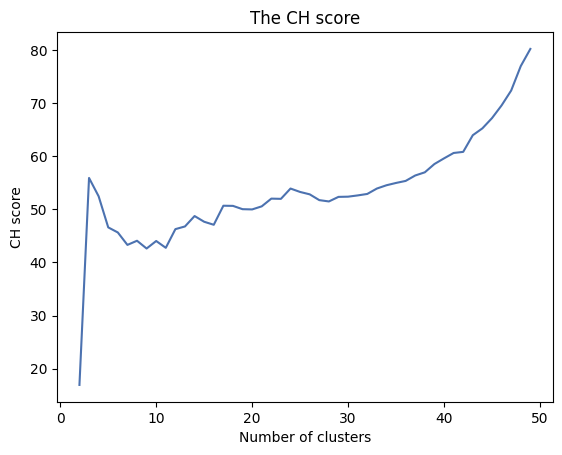

In [ ]:
calinski_harabasz_method(data, 'complete')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 10, linkage='complete')
labels = clust.fit_predict(data)

In [ ]:
calinski_harabasz_score(data, labels)

44.0457637818293

In [ ]:
cluster_dict = print_clusters(drawdowns_df, labels)

Cluster 5: AAPL, COST, EA, EQIX, F
Cluster 1: ABBV, ADSK, AMGN, ATVI, BAC, BKNG, BLK, CVX, GILD, IBM, INTC, M, MA, QCOM, STX
Cluster 9: ADBE, AZN, BIIB, BK, C, COP, JNJ
Cluster 6: AMZN, AVGO, GM, GS, IT, JPM, PSA, REGN, V
Cluster 3: CCI, LUMN, META, MS, MSFT, NVDA, SCHW, SLB
Cluster 0: EBAY, PFE, PLD, TXN
Cluster 7: EOG, INCY, JWN, LLY
Cluster 4: GOOG, HPQ, VZ, XOM
Cluster 2: MRK, MU, NFLX, VRTX, WFC, WMT
Cluster 8: ORCL, SPG, STT, T, UNH


In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio

['COST', 'BLK', 'ADBE', 'AMZN', 'MSFT', 'EBAY', 'LLY', 'GOOG', 'WMT', 'ORCL']

In [ ]:
weights = optimize_portfolio(drawdowns_df_cut, portfolio, (0, 0.2))

OrderedDict([('COST', 0.2), ('BLK', 0.2), ('ADBE', 0.0), ('AMZN', 0.0), ('MSFT', 0.0), ('EBAY', 0.07686), ('LLY', 0.08667), ('GOOG', 0.2), ('WMT', 0.03647), ('ORCL', 0.2)])

Expected annual return: 49.5%
Annual volatility: 16.3%
Sharpe Ratio: 2.91


##### Cheking stability

In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2021-06-01',
                    '2021-07-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 4.4%
Annual volatility: 4.0%
Sharpe Ratio: 1.12
(0.044308815490902626, 0.039549574151225356, 1.1203360956929498)
Beta: 1.3586589482165792
Cumulative return: 4.23%
Index stats
Expected return: 2.8%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2021-06-01',
                    '2021-08-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 10.0%
Annual volatility: 5.3%
Sharpe Ratio: 1.87
(0.09975756964583106, 0.05339585832716984, 1.8682641832366729)
Beta: 1.079610946468509
Cumulative return: 9.73%
Index stats
Expected return: 4.6%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2021-06-01',
                    '2021-09-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 17.5%
Annual volatility: 6.0%
Sharpe Ratio: 2.92
(0.17459500535672245, 0.05972913641899051, 2.923112836120146)
Beta: 1.023588680380411
Cumulative return: 17.17%
Index stats
Expected return: 7.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2021-07-01',
                    '2021-08-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 5.6%
Annual volatility: 3.8%
Sharpe Ratio: 1.48
(0.055951381908962844, 0.03768685428610054, 1.4846392188694435)
Beta: 0.9719898680787814
Cumulative return: 5.32%
Index stats
Expected return: 1.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2021-08-01',
                    '2021-09-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 6.6%
Annual volatility: 2.8%
Sharpe Ratio: 2.34
(0.06613481118690111, 0.02830481003252653, 2.336521994350153)
Beta: 0.9377206910470195
Cumulative return: 6.32%
Index stats
Expected return: 3.1%
Volatility: 0.0%


#### Average Linkage

##### Building a portfolio

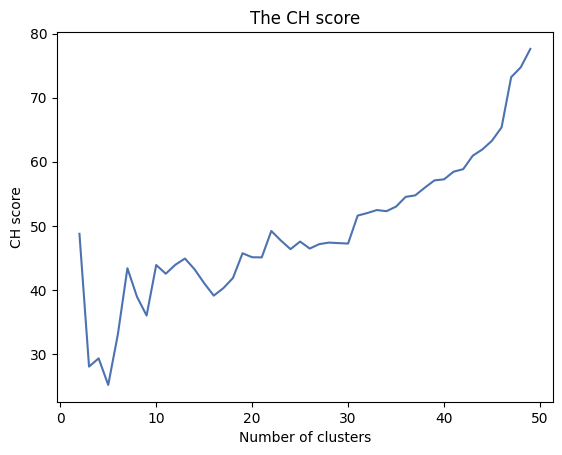

In [ ]:
calinski_harabasz_method(data, 'average')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 11, linkage='average')
labels = clust.fit_predict(data)

In [ ]:
calinski_harabasz_score(data, labels)

42.53923191453293

In [ ]:
cluster_dict = print_clusters(drawdowns_df, labels)

Cluster 9: AAPL, ADBE, AZN, BIIB, BK, C, COP, COST, EA, F, JNJ
Cluster 1: ABBV, ADSK, BKNG, BLK, CCI, CVX, GILD, M, MA, MS, MSFT, STX
Cluster 0: AMGN, ATVI, BAC, EOG, GM, GS, IBM, INCY, INTC, IT, JPM, JWN, LLY, QCOM
Cluster 3: AMZN, AVGO, LUMN, META, NVDA, ORCL, PSA, REGN, SCHW, SLB, SPG, STT, T
Cluster 6: EBAY, PFE, V
Cluster 5: EQIX
Cluster 4: GOOG, HPQ, VZ, XOM
Cluster 2: MRK, MU, NFLX
Cluster 8: PLD, TXN
Cluster 7: UNH
Cluster 10: VRTX, WFC, WMT


In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio

['COST',
 'MSFT',
 'GS',
 'NVDA',
 'EBAY',
 'EQIX',
 'GOOG',
 'MU',
 'PLD',
 'UNH',
 'WMT']

In [ ]:
weights = optimize_portfolio(drawdowns_df_cut, portfolio, (0, 0.2))

OrderedDict([('COST', 0.18456), ('MSFT', 0.0), ('GS', 0.2), ('NVDA', 0.05972), ('EBAY', 0.06035), ('EQIX', 0.0), ('GOOG', 0.2), ('MU', 0.13122), ('PLD', 0.02151), ('UNH', 0.10129), ('WMT', 0.04135)])

Expected annual return: 60.8%
Annual volatility: 18.8%
Sharpe Ratio: 3.13


##### Cheking stability

In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2021-06-01',
                    '2021-07-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 2.9%
Annual volatility: 3.7%
Sharpe Ratio: 0.80
(0.02935456437022085, 0.036885550190407235, 0.7958282909890021)
Beta: 1.218484259249689
Cumulative return: 2.8%
Index stats
Expected return: 2.8%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2021-06-01',
                    '2021-08-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 5.8%
Annual volatility: 5.2%
Sharpe Ratio: 1.12
(0.057593081117137616, 0.051612253654372955, 1.1158799904924888)
Beta: 1.0909299810922841
Cumulative return: 5.61%
Index stats
Expected return: 4.6%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2021-06-01',
                    '2021-09-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 12.8%
Annual volatility: 5.9%
Sharpe Ratio: 2.18
(0.12773284941521254, 0.05855077884665112, 2.181573873675608)
Beta: 1.055471261650868
Cumulative return: 12.56%
Index stats
Expected return: 7.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2021-07-01',
                    '2021-08-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 2.9%
Annual volatility: 3.8%
Sharpe Ratio: 0.76
(0.028847090857945932, 0.03786852343161401, 0.761769624053082)
Beta: 1.0659310228571237
Cumulative return: 2.74%
Index stats
Expected return: 1.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2021-08-01',
                    '2021-09-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 6.1%
Annual volatility: 2.9%
Sharpe Ratio: 2.13
(0.061040396226151886, 0.028703530684902636, 2.126581461222736)
Beta: 1.032597871175107
Cumulative return: 5.82%
Index stats
Expected return: 3.1%
Volatility: 0.0%


#### Single Linkage

##### Building a portfolio

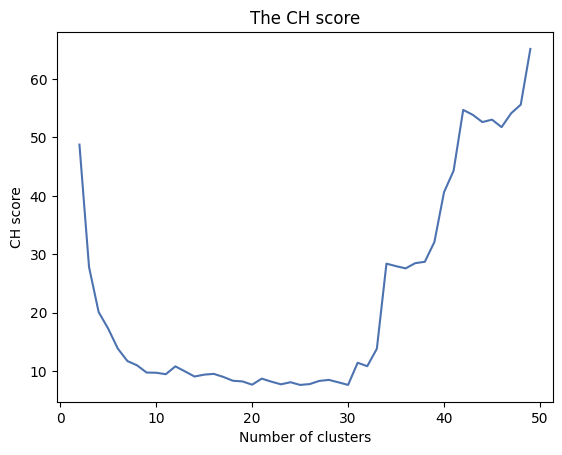

In [ ]:
calinski_harabasz_method(data, 'single')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 10, linkage='single')
labels = clust.fit_predict(data)

In [ ]:
calinski_harabasz_score(data, labels)

9.739710349541834

In [ ]:
cluster_dict = print_clusters(drawdowns_df, labels)

Cluster 0: AAPL, ABBV, ADBE, ADSK, AMGN, AMZN, ATVI, AVGO, AZN, BAC, BIIB, BK, BKNG, BLK, C, CCI, COP, COST, CVX, EA, EBAY, EOG, F, GILD, GM, GS, IBM, INCY, INTC, IT, JNJ, JPM, JWN, LUMN, M, MA, META, NVDA, ORCL, PLD, PSA, QCOM, REGN, SCHW, SLB, SPG, STT, STX, T, TXN, V
Cluster 9: EQIX
Cluster 2: GOOG, HPQ, VZ, XOM
Cluster 8: LLY
Cluster 1: MRK, NFLX
Cluster 3: MS, MSFT
Cluster 5: MU
Cluster 4: PFE
Cluster 7: UNH
Cluster 6: VRTX, WFC, WMT


In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
weights = optimize_portfolio(drawdowns_df_cut, portfolio, (0, 0.2))

OrderedDict([('COST', 0.2), ('EQIX', 0.0), ('GOOG', 0.2), ('LLY', 0.0633), ('NFLX', 0.0), ('MSFT', 0.0), ('MU', 0.2), ('PFE', 0.08466), ('UNH', 0.16077), ('WMT', 0.09128)])

Expected annual return: 46.4%
Annual volatility: 17.7%
Sharpe Ratio: 2.51


##### Cheking stability

In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2021-06-01',
                    '2021-07-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 1.9%
Annual volatility: 3.8%
Sharpe Ratio: 0.50
(0.01906273443995713, 0.038343932781213105, 0.49715125855053294)
Beta: 1.1895550752725415
Cumulative return: 1.82%
Index stats
Expected return: 2.8%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2021-06-01',
                    '2021-08-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 6.4%
Annual volatility: 4.6%
Sharpe Ratio: 1.38
(0.06433238329716028, 0.04646409053567719, 1.3845613366253886)
Beta: 0.8689965138532508
Cumulative return: 6.27%
Index stats
Expected return: 4.6%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2021-06-01',
                    '2021-09-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 10.5%
Annual volatility: 5.7%
Sharpe Ratio: 1.84
(0.10462779459293335, 0.05692211807035445, 1.8380868129962373)
Beta: 0.8304263636366638
Cumulative return: 10.28%
Index stats
Expected return: 7.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2021-07-01',
                    '2021-08-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 4.4%
Annual volatility: 2.8%
Sharpe Ratio: 1.59
(0.04434667948843336, 0.027831312011405127, 1.5934095909765347)
Beta: 0.7314205543632589
Cumulative return: 4.21%
Index stats
Expected return: 1.7%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2021-08-01',
                    '2021-09-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 3.0%
Annual volatility: 3.4%
Sharpe Ratio: 0.88
(0.03023879074396978, 0.034233361012737176, 0.8833135236916662)
Beta: 0.7972720263124874
Cumulative return: 2.89%
Index stats
Expected return: 3.1%
Volatility: 0.0%


## Period 2 - crisis (year 2022)

### Without clustering

In [ ]:
port = list(df_stocks.columns)

In [ ]:
weights = optimize_portfolio(stocks_df, port, (0, 1))

OrderedDict([('A', 0.0), ('AAPL', 0.0), ('ABBV', 0.0), ('ABT', 0.0), ('ACN', 0.0), ('ADBE', 0.0), ('ADI', 0.0), ('ADM', 0.0), ('ADP', 0.0), ('ADSK', 0.0), ('AEP', 0.0), ('AIG', 0.0), ('AJG', 0.0), ('AMAT', 0.0), ('AMD', 0.0), ('AMGN', 0.0), ('AMT', 0.0), ('AMZN', 0.0), ('ANET', 0.02171), ('AON', 0.0), ('APD', 0.0), ('APH', 0.0), ('ATVI', 0.0), ('AVGO', 0.0), ('AXP', 0.0), ('AZO', 0.05487), ('BA', 0.0), ('BAC', 0.0), ('BDX', 0.0), ('BIIB', 0.0), ('BKNG', 0.0), ('BLK', 0.0), ('BMY', 0.0), ('BRK-B', 0.0), ('BSX', 0.0), ('C', 0.0), ('CAT', 0.0), ('CB', 0.0), ('CCI', 0.0), ('CDNS', 0.0), ('CHTR', 0.0), ('CI', 0.0), ('CL', 0.0), ('CMCSA', 0.0), ('CME', 0.0), ('CMG', 0.0), ('COF', 0.0), ('COP', 0.04508), ('COST', 0.0), ('CRM', 0.0), ('CSCO', 0.0), ('CSX', 0.0), ('CTAS', 0.0), ('CTVA', 0.0), ('CVS', 0.0), ('CVX', 0.0), ('D', 0.0), ('DE', 0.0), ('DG', 0.0), ('DHR', 0.0), ('DIS', 0.0), ('DOW', 0.0), ('DUK', 0.0), ('DXCM', 0.0), ('ECL', 0.0), ('EL', 0.0), ('ELV', 0.0), ('EMR', 0.0), ('EOG', 0.0),

In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-01-01',
                    '2022-02-01',
                    port,
                    weights)

Portfolio stats
Expected annual return: -4.8%
Annual volatility: 5.6%
Sharpe Ratio: -0.86
(-0.04765886711663095, 0.05567980126645598, -0.8559453524009396)
Beta: 0.9415048733223075
Cumulative return: -4.56%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-01-01',
                    '2022-03-01',
                    port,
                    weights)

/usr/local/lib/python3.10/dist-packages/pypfopt/risk_models.py:68: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


Portfolio stats
Expected annual return: -7.1%
Annual volatility: 8.6%
Sharpe Ratio: -0.83
(-0.07115368812511685, 0.08564243436927897, -0.8308228117186798)
Beta: 0.900984557472361
Cumulative return: -6.98%
Index stats
Expected return: -10.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-01-01',
                    '2022-04-01',
                    port,
                    weights)

/usr/local/lib/python3.10/dist-packages/pypfopt/risk_models.py:68: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pypfopt/risk_models.py:87: UserWarning: Could not fix matrix. Please try a different risk model.
  warnings.warn(


Portfolio stats
Expected annual return: 0.9%
Annual volatility: 10.9%
Sharpe Ratio: 0.09
(0.009410103811471303, 0.10874261332583515, 0.08653556801393923)
Beta: 0.8930442090519309
Cumulative return: 0.9%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-02-01',
                    '2022-03-01',
                    port,
                    weights)

Portfolio stats
Expected annual return: -2.9%
Annual volatility: 6.8%
Sharpe Ratio: -0.42
(-0.02883638862606633, 0.06797157387941567, -0.4242418849565445)
Beta: 0.914564246754434
Cumulative return: -2.78%
Index stats
Expected return: -5.3%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-03-01',
                    '2022-04-01',
                    port,
                    weights)

Portfolio stats
Expected annual return: 8.9%
Annual volatility: 6.6%
Sharpe Ratio: 1.35
(0.08914428588846113, 0.06622491506029939, 1.3460838085982156)
Beta: 0.8995586086783879
Cumulative return: 8.52%
Index stats
Expected return: 5.6%
Volatility: 0.0%


### Correlation

In [ ]:
stocks_df = get_df_between_dates(df_stocks, '2021-01-01', '2022-01-01')

In [ ]:
df_stocks.isna().sum().sum()

0

In [ ]:
stocks_df.shape

(252, 200)

In [ ]:
index_2022 = get_df_between_dates(index_df, '2021-01-01', '2022-01-01')

In [ ]:
ext_df = get_df_between_dates(df_stocks, '2019-01-01', '2022-01-01')

In [ ]:
ext_df.isna().sum().sum()

0

In [ ]:
returns = get_sharpe_ratio_info(ext_df)

In [ ]:
returns

,ticker,mean_return,var,sharpe_ratio
0,A,0.353777,0.078458,4.254188
1,AAPL,0.667084,0.116413,5.558545
2,ABBV,0.210347,0.078388,2.428266
3,ABT,0.285318,0.078861,3.364388
4,ACN,0.453582,0.080485,5.387145
...,...,...,...,...
195,WM,0.256698,0.055663,4.252345
196,WMT,0.177715,0.049314,3.198191
197,XEL,0.150224,0.069637,1.870040
198,XOM,0.017898,0.133500,-0.015747


In [ ]:
dissimilarity = get_corr_dissimilarity_matrix(ext_df)

In [ ]:
dissimilarity

array([[0.        , 0.35331848, 0.37214384, ..., 0.84325493, 1.39753177,
        0.37408166],
       [0.        , 0.        , 0.34691876, ..., 0.67005125, 1.56898056,
        0.28604548],
       [0.        , 0.        , 0.        , ..., 0.82388985, 1.46441726,
        0.45043397],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 1.68833071,
        0.64910483],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.49812106],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
np.isnan(dissimilarity).sum()
# dissimilarity.isnan()

0

#### Ward Linkage

##### Building a portfolio

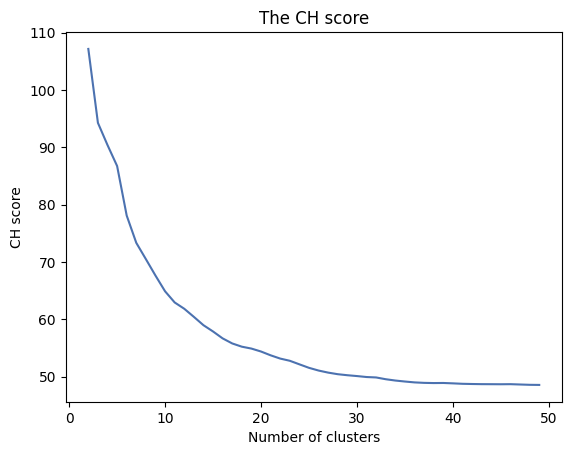

In [ ]:
calinski_harabasz_method(dissimilarity, 'ward')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 10, linkage='ward') #8
labels = clust.fit_predict(dissimilarity)

In [ ]:
calinski_harabasz_score(dissimilarity, labels)

64.87066078721324

In [ ]:
cluster_dict = print_clusters(stocks_df, labels)

Cluster 1: A, AAPL, ABBV, ABT, ACN, ADBE, ADI, ADM, ADP, ADSK, AJG, AMAT, AMD, AMGN, AMT, AMZN, ANET, AON, APD, APH, ATVI, AVGO, AZO
Cluster 3: AEP, AIG, BA, BDX, BIIB
Cluster 7: AXP, BAC, BKNG, BLK, BRK-B, CAT, CB, CCI, CDNS, CHTR, CL, CMCSA, CMG, COF, COST, CRM, CSX, CTAS, CVS
Cluster 6: BMY, BSX, C, CI, CME, COP, CSCO, CTVA, CVX, D, DOW, EOG
Cluster 0: DE, DG, DHR, DIS, DUK, DXCM, ECL, EL, ELV, EMR, EQIX, ETN, EW, F, FCX, FDX, FTNT, GIS, GM, GOOG, GOOGL, GS, HCA, HD, HLT, HON, HSY, HUM, ICE, IDXX, INTU, ISRG, ITW, JCI, JNJ, KLAC
Cluster 2: EXC, FISV, GD, GE, GILD, HES, IBM, INTC, JPM, KMB, KO, LHX, LMT, MAR, MMM, MO, MPC, MRK
Cluster 5: LIN, LLY, LOW, LRCX, MA, MCD, MCHP, MCK, MCO, MDLZ, MDT, MET, META, MMC, MNST, MRNA, MS, MSCI, MSFT, MSI, MU, NEE, NEM, NFLX, NKE, NOW, NSC, NUE, NVDA, NXPI, ORCL, ORLY
Cluster 8: NOC, O, OXY, PSX, PXD, RTX, SLB
Cluster 9: PEP, PFE, PG, PGR, PH, PLD, PM, PNC, PSA, PYPL, QCOM, REGN, ROP, SBUX, SCHW, SHW, SNPS, SO, SPGI, SYK
Cluster 4: SRE, SYY, T, TDG

In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio

['AAPL', 'AEP', 'COST', 'CSCO', 'DHR', 'LHX', 'MSFT', 'NOC', 'SNPS', 'TMO']

In [ ]:
returns[returns['ticker'].isin(portfolio)]

,ticker,mean_return,var,sharpe_ratio
1,AAPL,0.667084,0.116412,5.558551
10,AEP,0.104357,0.064567,1.306514
48,COST,0.429247,0.048848,8.377905
50,CSCO,0.173317,0.090686,1.690648
59,DHR,0.490812,0.069625,6.762142
106,LHX,0.190497,0.088647,1.923331
131,MSFT,0.509491,0.092067,5.316710
138,NOC,0.182134,0.081540,1.988401
168,SNPS,0.636691,0.113111,5.452085
180,TMO,0.452183,0.081688,5.290635


In [ ]:
weights = optimize_portfolio(stocks_df, portfolio, (0, 0.2))

OrderedDict([('AAPL', 0.0), ('AEP', 0.0), ('COST', 0.2), ('CSCO', 0.2), ('DHR', 0.2), ('LHX', 0.0), ('MSFT', 0.2), ('NOC', 0.2), ('SNPS', 0.0), ('TMO', 0.0)])

Expected annual return: 47.2%
Annual volatility: 13.0%
Sharpe Ratio: 3.48


##### Cheking stability

In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-01-01',
                    '2022-02-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -9.0%
Annual volatility: 5.1%
Sharpe Ratio: -1.74
(-0.08958374385605575, 0.05142107970302307, -1.74215991522226)
Beta: 0.8835221655209748
Cumulative return: -8.55%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-01-01',
                    '2022-03-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -5.6%
Annual volatility: 8.1%
Sharpe Ratio: -0.69
(-0.05591861829272933, 0.08133862806651052, -0.6874792410686437)
Beta: 0.8286953744580683
Cumulative return: -5.48%
Index stats
Expected return: -10.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-01-01',
                    '2022-04-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -1.2%
Annual volatility: 9.9%
Sharpe Ratio: -0.12
(-0.012345185691069176, 0.09934297805252278, -0.12426832709345856)
Beta: 0.7623220558073954
Cumulative return: -1.22%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-02-01',
                    '2022-03-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 3.3%
Annual volatility: 6.3%
Sharpe Ratio: 0.53
(0.033242065399544864, 0.06285011354956944, 0.5289101884171948)
Beta: 0.8308063947502289
Cumulative return: 3.13%
Index stats
Expected return: -5.3%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-03-01',
                    '2022-04-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 5.0%
Annual volatility: 5.8%
Sharpe Ratio: 0.86
(0.04997999574686976, 0.05797495556715792, 0.8620963182795917)
Beta: 0.7008168236094002
Cumulative return: 4.78%
Index stats
Expected return: 5.6%
Volatility: 0.0%


#### Complete Linkage

##### Building a portfolio

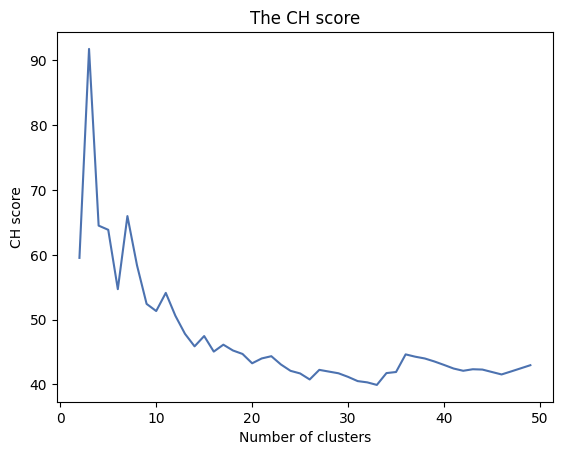

In [ ]:
calinski_harabasz_method(dissimilarity, 'complete')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 10, linkage='complete') #5
labels = clust.fit_predict(dissimilarity)

In [ ]:
calinski_harabasz_score(dissimilarity, labels)

51.33167479358458

In [ ]:
cluster_dict = print_clusters(stocks_df, labels)

Cluster 6: A, AAPL, ABBV, ABT, ACN, ADBE, ADI, ADM, ADP, ADSK, AJG, AMAT, AMD, AMT, AMZN, ANET, AON, APD, APH, AVGO, AXP, AZO, BAC, BKNG, BLK, BMY, BRK-B, CAT, CB, CCI, CDNS, CHTR, CI, CL, CMCSA, CMG, COF, COST, CRM, CSX, CTAS, CVS, DE, DHR
Cluster 2: AEP, AIG, AMGN, ATVI
Cluster 3: BA, BDX, BIIB
Cluster 5: BSX, C, CME, COP, CSCO, CVX, D, DOW, EOG
Cluster 8: CTVA
Cluster 4: DG, DIS, DUK, DXCM, ECL, EL, ELV, EMR, EQIX, ETN, EW, F, FCX, FTNT, GIS, GM, GOOG, GOOGL, GS, HCA, HD, HLT, HON, HSY, HUM, ICE, IDXX, INTU, ISRG, ITW, JCI, JNJ, KLAC
Cluster 1: EXC, FDX, FISV, GD, GE, GILD, HES, IBM, INTC, KMB, LMT
Cluster 0: JPM, KO, LHX, LIN, LLY, LOW, LRCX, MA, MAR, MCD, MCHP, MCK, MCO, MDLZ, MDT, MET, META, MMC, MMM, MNST, MO, MPC, MRK, MRNA, MS, MSCI, MSFT, MSI, MU, NEE, NEM, NFLX, NKE, NOC, NOW, NSC, NUE, NVDA, NXPI, O, ORCL, ORLY, PEP, PFE, PG, PGR, PH, PLD, PM, PNC, PSA, PSX, PXD, PYPL, QCOM, REGN, ROP, RTX, SLB, SRE, SYY, T, TFC
Cluster 7: OXY
Cluster 9: SBUX, SCHW, SHW, SNPS, SO, SPGI, SYK

In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio

['COST', 'AEP', 'BDX', 'CSCO', 'CTVA', 'IDXX', 'KMB', 'MSFT', 'OXY', 'SNPS']

In [ ]:
returns[returns['ticker'].isin(portfolio)]

,ticker,mean_return,var,sharpe_ratio
10,AEP,0.104357,0.064567,1.306514
28,BDX,0.059272,0.071212,0.551477
48,COST,0.429247,0.048848,8.377905
50,CSCO,0.173317,0.090686,1.690648
53,CTVA,-0.336974,0.401657,-0.888753
95,IDXX,0.533865,0.102849,4.996299
104,KMB,0.120197,0.054645,1.833613
131,MSFT,0.509491,0.092067,5.316710
147,OXY,-0.197719,0.538779,-0.404098
168,SNPS,0.636691,0.113111,5.452085


In [ ]:
weights = optimize_portfolio(stocks_df, portfolio, (0, 0.2))

OrderedDict([('COST', 0.2), ('AEP', 0.09112), ('BDX', 0.0), ('CSCO', 0.2), ('CTVA', 0.01509), ('IDXX', 0.03463), ('KMB', 0.17213), ('MSFT', 0.2), ('OXY', 0.08702), ('SNPS', 0.0)])

Expected annual return: 41.3%
Annual volatility: 12.5%
Sharpe Ratio: 3.15


##### Cheking stability

In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-01-01',
                    '2022-02-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -5.1%
Annual volatility: 4.4%
Sharpe Ratio: -1.16
(-0.05142314327669598, 0.04420133950480208, -1.163384274160047)
Beta: 0.7776320748937016
Cumulative return: -4.93%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-01-01',
                    '2022-03-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -3.9%
Annual volatility: 6.4%
Sharpe Ratio: -0.61
(-0.03942040342756708, 0.06446635011471358, -0.6114880609406472)
Beta: 0.6624735106983219
Cumulative return: -3.88%
Index stats
Expected return: -10.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-01-01',
                    '2022-04-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 3.7%
Annual volatility: 8.5%
Sharpe Ratio: 0.44
(0.03721166158072882, 0.08533028968310599, 0.43608971349942716)
Beta: 0.6572781999041948
Cumulative return: 3.61%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-02-01',
                    '2022-03-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 0.6%
Annual volatility: 4.8%
Sharpe Ratio: 0.12
(0.006021108087123471, 0.04821693015187859, 0.12487539269210154)
Beta: 0.612558070784889
Cumulative return: 0.56%
Index stats
Expected return: -5.3%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-03-01',
                    '2022-04-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 7.0%
Annual volatility: 5.6%
Sharpe Ratio: 1.25
(0.06978058224919619, 0.05586747823305543, 1.2490376236081606)
Beta: 0.6643761093691661
Cumulative return: 6.67%
Index stats
Expected return: 5.6%
Volatility: 0.0%


#### Average Linkage

##### Building a portfolio

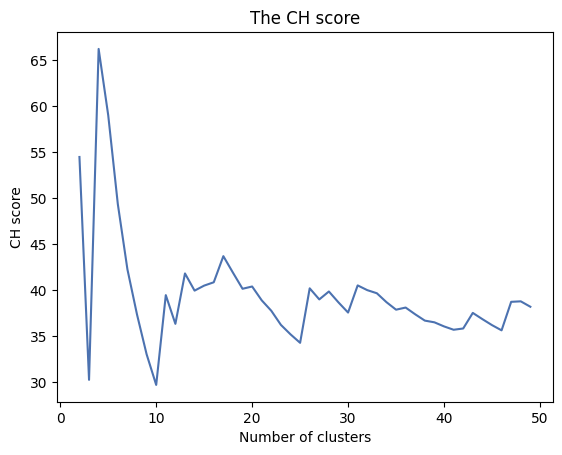

In [ ]:
calinski_harabasz_method(dissimilarity, 'average')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 10, linkage='average') # 5
labels = clust.fit_predict(dissimilarity)

In [ ]:
calinski_harabasz_score(dissimilarity, labels)

29.671323658508907

In [ ]:
cluster_dict = print_clusters(stocks_df, labels)

Cluster 3: A, AAPL, ABBV, ABT, ACN, ADBE, ADI, ADM, ADP, ADSK, AJG, AMAT, AMD, AMGN, AMT, AMZN, ANET, AON, APD, APH, ATVI, AVGO, AXP, AZO, BAC, BKNG, BLK, BMY, BRK-B, CAT, CB, CCI, CDNS, CHTR, CI, CL, CMCSA, CMG, COF, COST, CRM, CSX, CTAS, CVS, DE, DG, DHR, DIS, DUK, DXCM, ECL, EL, ELV, EMR, EQIX, ETN, EW, F, FCX, FDX, FTNT, GIS, GM, HUM
Cluster 6: AEP, AIG
Cluster 9: BA
Cluster 7: BDX, BIIB
Cluster 1: BSX, C, CME, COP, CSCO, CVX, D
Cluster 8: CTVA
Cluster 2: DOW, EOG
Cluster 4: EXC, FISV, GD, GE, GILD, HES, IBM, INTC, KMB, LMT
Cluster 0: GOOG, GOOGL, GS, HCA, HD, HLT, HON, HSY, ICE, IDXX, INTU, ISRG, ITW, JCI, JNJ, JPM, KLAC, KO, LHX, LIN, LLY, LOW, LRCX, MA, MAR, MCD, MCHP, MCK, MCO, MDLZ, MDT, MET, META, MMC, MMM, MNST, MO, MPC, MRK, MRNA, MS, MSCI, MSFT, MSI, MU, NEE, NEM, NFLX, NKE, NOC, NOW, NSC, NUE, NVDA, NXPI, ORCL, ORLY, PEP, PFE, PG, PGR, PH, PLD, PM, PNC, PSA, PSX, PXD, PYPL, QCOM, REGN, ROP, RTX, SBUX, SCHW, SHW, SLB, SNPS, SO, SPGI, SRE, SYK, SYY, T, TDG, TEL, TFC, TGT, T

In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio

['COST', 'AEP', 'BA', 'BDX', 'CSCO', 'CTVA', 'EOG', 'KMB', 'SNPS', 'O']

In [ ]:
returns[returns['ticker'].isin(portfolio)]

,ticker,mean_return,var,sharpe_ratio
10,AEP,0.104357,0.064567,1.306514
26,BA,-0.138302,0.325989,-0.485604
28,BDX,0.059272,0.071212,0.551477
48,COST,0.429247,0.048848,8.377905
50,CSCO,0.173317,0.090686,1.690648
53,CTVA,-0.336974,0.401657,-0.888753
68,EOG,0.026808,0.291983,0.023316
104,KMB,0.120197,0.054645,1.833613
144,O,0.105975,0.133074,0.646066
168,SNPS,0.636691,0.113111,5.452085


In [ ]:
weights = optimize_portfolio(stocks_df, portfolio, (0, 0.2))

OrderedDict([('COST', 0.2), ('AEP', 0.0808), ('BA', 0.0), ('BDX', 0.0), ('CSCO', 0.2), ('CTVA', 0.0), ('EOG', 0.17711), ('KMB', 0.07592), ('SNPS', 0.06618), ('O', 0.2)])

Expected annual return: 46.0%
Annual volatility: 13.8%
Sharpe Ratio: 3.20


##### Cheking stability

In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-01-01',
                    '2022-02-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -1.7%
Annual volatility: 4.4%
Sharpe Ratio: -0.40
(-0.017360484399676576, 0.043528882529414524, -0.3988267878906672)
Beta: 0.7524450436665456
Cumulative return: -1.7%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-01-01',
                    '2022-03-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -1.9%
Annual volatility: 6.1%
Sharpe Ratio: -0.32
(-0.01939932299791202, 0.060759577975992, -0.3192800813326468)
Beta: 0.601349292163336
Cumulative return: -1.92%
Index stats
Expected return: -10.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-01-01',
                    '2022-04-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 4.2%
Annual volatility: 7.2%
Sharpe Ratio: 0.59
(0.04244349034081835, 0.07219373219510841, 0.5879110145755032)
Beta: 0.5214904071026644
Cumulative return: 4.16%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-02-01',
                    '2022-03-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -0.4%
Annual volatility: 4.4%
Sharpe Ratio: -0.09
(-0.0038728813086601043, 0.044499692403299096, -0.0870316422315984)
Beta: 0.5221182024827657
Cumulative return: -0.37%
Index stats
Expected return: -5.3%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-03-01',
                    '2022-04-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 6.5%
Annual volatility: 3.9%
Sharpe Ratio: 1.68
(0.06501299242257544, 0.03877259711906737, 1.676776828308045)
Beta: 0.41305131257954386
Cumulative return: 6.22%
Index stats
Expected return: 5.6%
Volatility: 0.0%


#### Single Linkage

##### Building a portfolio

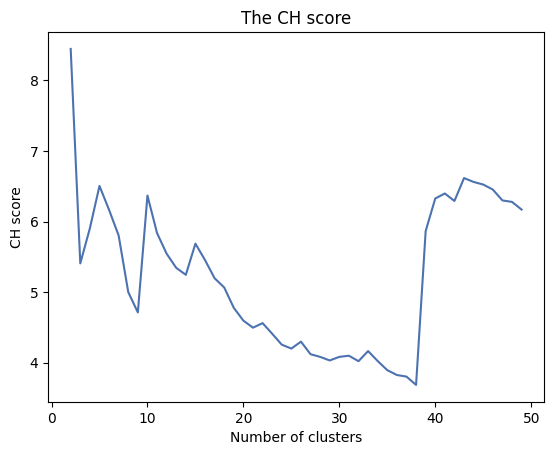

In [ ]:
calinski_harabasz_method(dissimilarity, 'single')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 10, linkage='single') #19
labels = clust.fit_predict(dissimilarity)

In [ ]:
calinski_harabasz_score(dissimilarity, labels)

6.3688573630780105

In [ ]:
cluster_dict = print_clusters(stocks_df, labels)

Cluster 1: A, AAPL, ABBV, ABT, ACN, ADBE, ADI, ADM, ADP, ADSK, AJG, AMAT, AMD, AMGN, AMT, AMZN, ANET, AON, APD, APH, ATVI, AVGO, AXP, AZO, BAC, BKNG, BLK, BMY, BRK-B, CAT, CB, CCI, CDNS, CHTR, CI, CL, CMCSA, CME, CMG, COF, COP, COST, CRM, CSCO, CSX, CTAS, CVS, CVX, DE, DG, DHR, DIS, DUK, DXCM, ECL, EL, ELV, EMR, EQIX, ETN, EW, EXC, F, FCX, FDX, FISV, FTNT, GD, GE, GILD, GIS, GM, GOOG, GOOGL, GS, HCA, HD, HES, HLT, HON, HSY, HUM, IBM, ICE, IDXX, INTC, INTU, ISRG, ITW, JCI, JNJ, JPM, KLAC, KMB, KO, LHX, LIN, LLY, LMT, LOW, LRCX, MA, MAR, MCD, MCHP, MCK, MCO, MDLZ, MDT, MET, META, MMC, MMM, MNST, MO, MPC, MRK, MRNA, MS, MSCI, MSFT, MSI, MU, NEE, NEM, NFLX, NKE, NOC, NOW, NSC, NUE, NVDA, NXPI, O, ORCL, ORLY, PEP, PFE, PG, PGR, PH, PLD, PM, PNC, PSA, PSX, PXD, PYPL, QCOM, REGN, ROP, RTX, SBUX, SCHW, SHW, SLB, SNPS, SO, SPGI, SRE, SYK, SYY, T, TDG, TEL, TFC, TGT, TJX, TMO, TMUS, TRV, TSLA, TT, TXN, UNH, UNP, UPS, USB, V, VLO, VRTX, VZ, WFC, WM, WMT, XEL, XOM, ZTS
Cluster 7: AEP
Cluster 6: AI

In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio

['COST', 'AEP', 'AIG', 'BA', 'BDX', 'CTVA', 'D', 'DOW', 'EOG', 'OXY']

In [ ]:
returns[returns['ticker'].isin(portfolio)]

,ticker,mean_return,var,sharpe_ratio
10,AEP,0.104357,0.064567,1.306514
11,AIG,0.163012,0.215457,0.663759
26,BA,-0.138302,0.325989,-0.485604
28,BDX,0.059272,0.071212,0.551477
48,COST,0.429247,0.048848,8.377905
53,CTVA,-0.336974,0.401657,-0.888753
56,D,0.076722,0.085633,0.662379
61,DOW,-0.208782,0.318301,-0.718759
68,EOG,0.026808,0.291983,0.023316
147,OXY,-0.197719,0.538779,-0.404098


In [ ]:
weights = optimize_portfolio(stocks_df, portfolio, (0, 0.2))

OrderedDict([('COST', 0.2), ('AEP', 0.2), ('AIG', 0.2), ('BA', 0.0), ('BDX', 0.11017), ('CTVA', 0.0), ('D', 0.08983), ('DOW', 0.0), ('EOG', 0.2), ('OXY', 0.0)])

Expected annual return: 43.1%
Annual volatility: 14.9%
Sharpe Ratio: 2.77


##### Cheking stability

In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-01-01',
                    '2022-02-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 3.9%
Annual volatility: 3.5%
Sharpe Ratio: 1.11
(0.03911825896682385, 0.03539660496705132, 1.1051415525086885)
Beta: 0.5084537635291967
Cumulative return: 3.69%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-01-01',
                    '2022-03-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 6.0%
Annual volatility: 5.3%
Sharpe Ratio: 1.13
(0.059937370050040434, 0.05285240517238793, 1.1340518913858997)
Beta: 0.41895638077600555
Cumulative return: 5.82%
Index stats
Expected return: -10.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-01-01',
                    '2022-04-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 14.6%
Annual volatility: 6.6%
Sharpe Ratio: 2.21
(0.14613647454816706, 0.06622892669814008, 2.2065354495963927)
Beta: 0.3595831115187466
Cumulative return: 14.36%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-02-01',
                    '2022-03-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 2.2%
Annual volatility: 4.1%
Sharpe Ratio: 0.53
(0.02178540723503441, 0.04107447234587894, 0.5303879999135319)
Beta: 0.37454052559158674
Cumulative return: 2.07%
Index stats
Expected return: -5.3%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-03-01',
                    '2022-04-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 8.7%
Annual volatility: 4.1%
Sharpe Ratio: 2.14
(0.08733679843392439, 0.04077872510490217, 2.141724593136564)
Beta: 0.2805272114919375
Cumulative return: 8.35%
Index stats
Expected return: 5.6%
Volatility: 0.0%


### Multiplicators

In [ ]:
data = indicators.copy()
data = data.drop('ticker', axis=1)

In [ ]:
data

,returnOnAssets,revenueGrowth,ebitdaMargins
0,0.20559,-0.025,0.32145
1,0.14829,0.071,0.48210
2,0.01906,0.094,0.10896
3,0.08166,-0.208,0.26399
4,0.12415,0.026,0.30742
...,...,...,...
186,0.03229,0.090,0.15852
187,0.09129,0.397,0.59845
188,0.05473,0.034,0.39396
189,0.18653,-0.170,0.25889


In [ ]:
returns = get_sharpe_ratio_info(get_df_between_dates(df_stocks,
                                                     '2020-01-01',
                                                     '2022-01-01'))

#### Ward Linkage

##### Building a portfolio

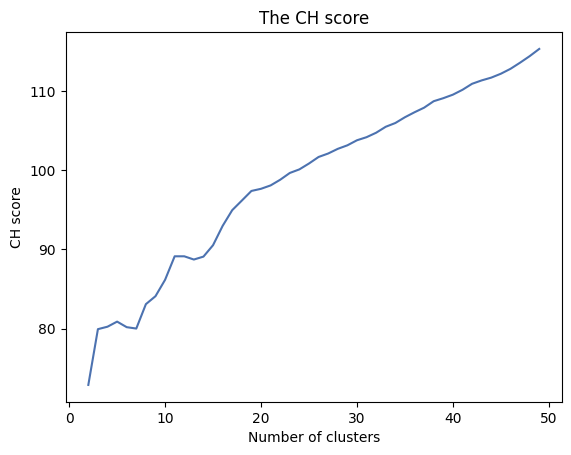

In [ ]:
calinski_harabasz_method(data, 'ward')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 10, linkage='ward') #17
labels = clust.fit_predict(data)

In [ ]:
calinski_harabasz_score(data, labels)

86.1512758136453

In [ ]:
cluster_dict = print_clusters(stocks_df[tickers], labels)

Cluster 4: AAPL, XOM, CVX, LLY, ABBV, MRK, LIN, VZ, DHR, TXN, CMCSA, BMY, QCOM, AMGN, COP, GILD, BLK, TMUS, SO, EOG, LRCX, FCX, PXD, MCO, APH, BIIB, NEM, NUE
Cluster 5: MSFT, V, MA, AVGO, MCD, UNP, AMT, VRTX, MO, CME, CSX, ICE, CCI, PSA, MSCI, HES, O
Cluster 0: AMZN, UNH, HD, PEP, COST, WMT, BAC, CRM, ACN, NKE, NFLX, WFC, RTX, LOW, SBUX, ELV, MS, GS, LMT, GE, CVS, AXP, MDLZ, C, TJX, CB, CI, SCHW, TGT, NOC, HUM, ETN, HCA, SHW, GIS, GD, MCK, GM, PNC, DG, CMG, KMB, ADM, TFC, DXCM, CTVA, ADSK, ECL, TRV, TEL, SYY, MET, TT, JCI, LHX
Cluster 6: NVDA, TMO, ABT, AMD, UPS, INTC, MPC, MMM, EL, FDX, VLO, PSX, DOW, AIG, COF
Cluster 2: GOOGL, GOOG, META, JNJ, PG, KO, CSCO, ADBE, PM, T, HON, INTU, IBM, MDT, AMAT, SYK, ISRG, ADP, REGN, MMC, ZTS, BSX, BDX, AON, ITW, CL, WM, CDNS, SNPS, ORLY, KLAC, EW, EMR, AZO, MSI, NSC, NXPI, EXC, AJG, A, MNST, IDXX, CTAS, XEL, HSY, CHTR
Cluster 3: BRK-B, TSLA, JPM, BA, DE, NOW, PGR, SLB, ATVI, F, USB, FTNT, PH
Cluster 7: NEE
Cluster 1: ORCL, PLD, SPGI, ADI, FISV, EQI

In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio

['DHR', 'PSA', 'COST', 'NVDA', 'IDXX', 'TSLA', 'NEE', 'PLD', 'ANET', 'MRNA']

In [ ]:
weights = optimize_portfolio(stocks_df, portfolio, (0, 0.2))

OrderedDict([('DHR', 0.08801), ('PSA', 0.2), ('COST', 0.2), ('NVDA', 0.08524), ('IDXX', 0.0), ('TSLA', 0.0), ('NEE', 0.0), ('PLD', 0.2), ('ANET', 0.18011), ('MRNA', 0.04665)])

Expected annual return: 80.6%
Annual volatility: 16.1%
Sharpe Ratio: 4.87


##### Cheking stability

In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-01-01',
                    '2022-02-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -10.3%
Annual volatility: 7.0%
Sharpe Ratio: -1.46
(-0.10291398329157535, 0.07030065934157687, -1.4639120636342378)
Beta: 1.189062575195632
Cumulative return: -9.84%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-01-01',
                    '2022-03-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -12.3%
Annual volatility: 10.5%
Sharpe Ratio: -1.18
(-0.12343696487046102, 0.10496358897652294, -1.1759979443735484)
Beta: 1.1538391730123372
Cumulative return: -12.06%
Index stats
Expected return: -10.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-01-01',
                    '2022-04-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -0.8%
Annual volatility: 13.2%
Sharpe Ratio: -0.06
(-0.00756523675260673, 0.13183168134805784, -0.05738557435699565)
Beta: 1.126075279469072
Cumulative return: -0.75%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-02-01',
                    '2022-03-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -2.8%
Annual volatility: 8.1%
Sharpe Ratio: -0.34
(-0.027615975464308353, 0.08059489502653974, -0.3426516711165697)
Beta: 1.1843617884239002
Cumulative return: -2.63%
Index stats
Expected return: -5.3%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-03-01',
                    '2022-04-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 13.7%
Annual volatility: 7.6%
Sharpe Ratio: 1.80
(0.1366698183379385, 0.07573288021809782, 1.8046298773313871)
Beta: 1.0793784688547905
Cumulative return: 13.06%
Index stats
Expected return: 5.6%
Volatility: 0.0%


#### Complete Linkage

##### Building a portfolio

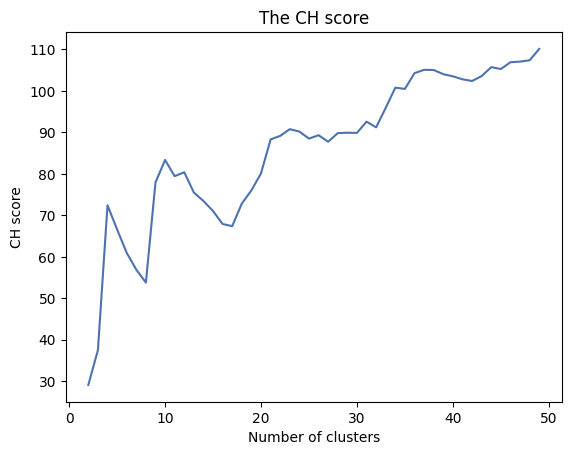

In [ ]:
calinski_harabasz_method(data, 'complete')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 10, linkage='complete')
labels = clust.fit_predict(data)

In [ ]:
calinski_harabasz_score(data, labels)

83.35296504473182

In [ ]:
cluster_dict = print_clusters(stocks_df[tickers], labels)

Cluster 6: AAPL, LLY, ABBV, MRK, TXN, BMY, QCOM, AMGN, COP, GILD, BLK, EOG, LRCX, FCX, PXD, MCO, NEM, NUE
Cluster 3: MSFT, V, MA, AVGO, MCD, UNP, AMT, VRTX, MO, CME, CSX, ICE, CCI, KLAC, PSA, MSCI, HES
Cluster 8: AMZN, UNH, HD, PEP, COST, WMT, BAC, CRM, ACN, NKE, NFLX, WFC, RTX, UPS, LOW, ELV, MS, GS, LMT, GE, CVS, AXP, MDLZ, C, TJX, CB, CI, SCHW, TGT, NOC, HUM, ETN, MPC, HCA, FDX, SHW, VLO, GIS, GD, MCK, PSX, GM, PNC, DG, KMB, ADM, TFC, DXCM, CTVA, ADSK, ECL, TRV, TEL, SYY, MET, TT, JCI, LHX
Cluster 2: NVDA, ABT, INTC, DOW, AIG, COF
Cluster 1: GOOGL, GOOG, META, XOM, JNJ, PG, CVX, KO, TMO, CSCO, LIN, ADBE, VZ, DHR, CMCSA, PM, AMD, ORCL, T, HON, INTU, SBUX, IBM, MDT, AMAT, SYK, ISRG, ADP, TMUS, REGN, MMC, ZTS, SO, FISV, BSX, BDX, AON, EQIX, ITW, CL, WM, CDNS, SNPS, MMM, EL, ORLY, EW, EMR, AZO, MSI, CMG, NSC, APH, ROP, NXPI, EXC, AJG, A, BIIB, MNST, IDXX, CTAS, XEL, HSY, CHTR
Cluster 9: BRK-B, TSLA, JPM, BA, DE, NOW, PGR, SLB, ATVI, F, USB, FTNT, PH
Cluster 7: NEE
Cluster 0: PLD, SPGI, 

In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio

['AAPL', 'PSA', 'COST', 'NVDA', 'DHR', 'TSLA', 'NEE', 'PLD', 'ANET', 'MRNA']

In [ ]:
weights = optimize_portfolio(stocks_df, portfolio, (0, 0.2))

OrderedDict([('AAPL', 0.0), ('PSA', 0.2), ('COST', 0.2), ('NVDA', 0.08524), ('DHR', 0.08801), ('TSLA', 0.0), ('NEE', 0.0), ('PLD', 0.2), ('ANET', 0.18011), ('MRNA', 0.04665)])

Expected annual return: 80.6%
Annual volatility: 16.1%
Sharpe Ratio: 4.87


##### Cheking stability

In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-01-01',
                    '2022-02-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -10.3%
Annual volatility: 7.0%
Sharpe Ratio: -1.46
(-0.10291398329157535, 0.07030065934157687, -1.4639120636342378)
Beta: 1.189062575195632
Cumulative return: -9.84%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-01-01',
                    '2022-03-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -12.3%
Annual volatility: 10.5%
Sharpe Ratio: -1.18
(-0.12343696487046102, 0.10496358897652294, -1.1759979443735484)
Beta: 1.153839173012337
Cumulative return: -12.06%
Index stats
Expected return: -10.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-01-01',
                    '2022-04-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -0.8%
Annual volatility: 13.2%
Sharpe Ratio: -0.06
(-0.00756523675260673, 0.13183168134805784, -0.05738557435699565)
Beta: 1.126075279469072
Cumulative return: -0.75%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-02-01',
                    '2022-03-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -2.8%
Annual volatility: 8.1%
Sharpe Ratio: -0.34
(-0.027615975464308353, 0.08059489502653974, -0.3426516711165697)
Beta: 1.1843617884239002
Cumulative return: -2.63%
Index stats
Expected return: -5.3%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-03-01',
                    '2022-04-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 13.7%
Annual volatility: 7.6%
Sharpe Ratio: 1.80
(0.1366698183379385, 0.07573288021809782, 1.8046298773313871)
Beta: 1.0793784688547905
Cumulative return: 13.06%
Index stats
Expected return: 5.6%
Volatility: 0.0%


#### Average Linkage

##### Building a portfolio

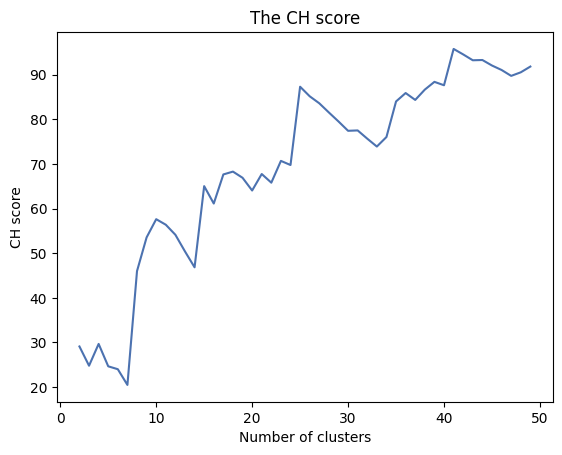

In [ ]:
calinski_harabasz_method(data, 'average')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 23, linkage='average')
labels = clust.fit_predict(data)

In [ ]:
calinski_harabasz_score(data, labels)

70.67907575962346

In [ ]:
cluster_dict = print_clusters(stocks_df[tickers], labels)

Cluster 3: AAPL, QCOM, COP, LRCX, NUE
Cluster 9: MSFT, META, ABBV, MCD, PM, BMY, AMGN, UNP, GILD, REGN, ZTS, CSX, KLAC, MCO, NSC, NXPI, HES
Cluster 2: AMZN, GOOGL, GOOG, UNH, JNJ, PG, HD, PEP, KO, CSCO, CRM, ACN, ADBE, NKE, NFLX, RTX, HON, INTU, LOW, SBUX, IBM, LMT, MDT, GE, AMAT, SYK, MDLZ, ISRG, TJX, ADP, MMC, CB, BSX, BDX, NOC, AON, ITW, CL, ETN, WM, CDNS, SNPS, HCA, ORLY, SHW, GIS, GD, EW, GM, DG, EMR, AZO, MSI, CMG, APH, KMB, DXCM, CTVA, EXC, ADSK, AJG, A, ECL, TRV, TEL, MNST, IDXX, TT, CTAS, JCI, XEL, HSY, LHX
Cluster 6: NVDA, ABT, DOW, AIG
Cluster 20: BRK-B, JPM, BA, NOW, PGR, F, USB
Cluster 1: TSLA, DE, BKNG, SLB, ATVI, FTNT, PH
Cluster 7: XOM, CVX, TMO, AMD, UPS, MPC, MMM, EL, FDX, VLO, PSX
Cluster 22: V, PSA
Cluster 8: MA, AVGO, VRTX, MO, MSCI
Cluster 10: LLY, MRK, LIN, VZ, DHR, CMCSA, T, BLK, TMUS, SO, FCX, BIIB, NEM, CHTR
Cluster 17: COST, WMT, BAC, WFC, ELV, MS, GS, CVS, AXP, C, CI, SCHW, TGT, HUM, MCK, PNC, ADM, TFC, SYY, MET
Cluster 5: TXN, EOG, PXD
Cluster 15: NEE
Clust

In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
# portfolio

In [ ]:
weights = optimize_portfolio(stocks_df, portfolio, (0, 0.2))

OrderedDict([('AAPL', 0.0), ('MSFT', 0.01949), ('IDXX', 0.0), ('NVDA', 0.05416), ('NOW', 0.0), ('TSLA', 0.0), ('TMO', 0.00842), ('PSA', 0.2), ('MSCI', 0.0), ('DHR', 0.06653), ('COST', 0.12433), ('TXN', 0.0), ('NEE', 0.0), ('SPGI', 0.0), ('INTC', 0.0), ('PLD', 0.2), ('ICE', 0.0), ('MU', 0.0), ('MRNA', 0.04518), ('SRE', 0.0), ('ANET', 0.11155), ('O', 0.0), ('COF', 0.17035)])

Expected annual return: 74.7%
Annual volatility: 13.8%
Sharpe Ratio: 5.27


##### Cheking stability

In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-01-01',
                    '2022-02-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -7.7%
Annual volatility: 6.2%
Sharpe Ratio: -1.24
(-0.07705033566341332, 0.061952654271099826, -1.2436970872345074)
Beta: 1.0715282124803434
Cumulative return: -7.36%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-01-01',
                    '2022-03-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -10.7%
Annual volatility: 9.4%
Sharpe Ratio: -1.13
(-0.10702102725822411, 0.09430934856746426, -1.1347870479846072)
Beta: 1.0719011586330098
Cumulative return: -10.46%
Index stats
Expected return: -10.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-01-01',
                    '2022-04-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -2.4%
Annual volatility: 12.2%
Sharpe Ratio: -0.20
(-0.023864226513636504, 0.12167191336642151, -0.1961358694324803)
Beta: 1.0692085721962084
Cumulative return: -2.36%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-02-01',
                    '2022-03-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -3.6%
Annual volatility: 7.4%
Sharpe Ratio: -0.49
(-0.03601662789163128, 0.07402428925814518, -0.48655148536489634)
Beta: 1.123269240036559
Cumulative return: -3.43%
Index stats
Expected return: -5.3%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-03-01',
                    '2022-04-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 9.9%
Annual volatility: 7.6%
Sharpe Ratio: 1.31
(0.09858777231451879, 0.07551496245165501, 1.3055395793599855)
Beta: 1.0874859754827715
Cumulative return: 9.42%
Index stats
Expected return: 5.6%
Volatility: 0.0%


#### Single Linkage

##### Building a portfolio

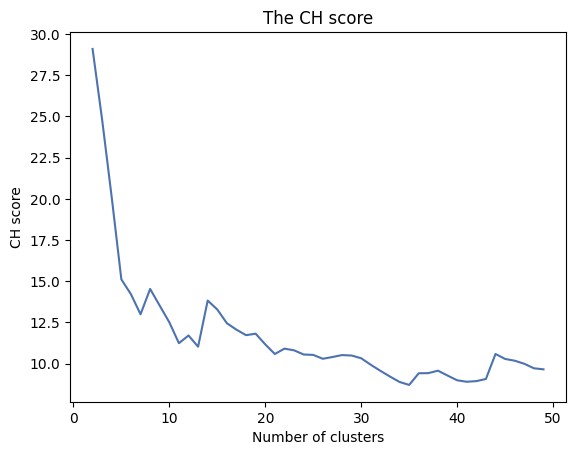

In [ ]:
calinski_harabasz_method(data, 'single')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 7, linkage='single')
labels = clust.fit_predict(data)

In [ ]:
calinski_harabasz_score(data, labels)

12.996169683528073

In [ ]:
cluster_dict = print_clusters(stocks_df[tickers], labels)

Cluster 0: AAPL, MSFT, AMZN, NVDA, GOOGL, BRK-B, GOOG, TSLA, UNH, META, XOM, JNJ, JPM, V, PG, MA, CVX, HD, LLY, ABBV, MRK, AVGO, PEP, KO, TMO, COST, WMT, MCD, CSCO, BAC, CRM, ACN, ABT, LIN, ADBE, VZ, DHR, TXN, CMCSA, NKE, PM, AMD, NFLX, WFC, BMY, RTX, ORCL, UPS, T, QCOM, AMGN, INTC, COP, HON, INTU, LOW, UNP, SBUX, BA, IBM, ELV, PLD, SPGI, MS, GS, LMT, MDT, DE, GILD, GE, BLK, BKNG, AMAT, CVS, SYK, AMT, AXP, ADI, MDLZ, NOW, ISRG, C, TJX, ADP, TMUS, REGN, PGR, MMC, VRTX, CB, MO, ZTS, CI, SCHW, SO, TGT, FISV, SLB, BSX, BDX, EOG, CME, LRCX, NOC, HUM, AON, EQIX, ITW, CSX, CL, ETN, WM, ATVI, MPC, ICE, FCX, CDNS, CCI, SNPS, MMM, HCA, EL, ORLY, FDX, SHW, VLO, KLAC, PXD, GIS, GD, EW, F, MCK, PSA, PSX, USB, GM, PNC, DG, D, EMR, AZO, MSI, CMG, MCO, NSC, APH, ROP, KMB, ADM, TFC, NXPI, DXCM, MCHP, MAR, CTVA, FTNT, EXC, ADSK, MSCI, AJG, A, ECL, BIIB, PH, HES, TRV, TEL, MNST, SYY, NEM, IDXX, MET, DOW, TT, CTAS, JCI, XEL, HSY, AIG, LHX, HLT, CHTR, NUE, COF
Cluster 3: NEE
Cluster 4: MU
Cluster 1: MRNA
C

In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio

['COST', 'NEE', 'MU', 'MRNA', 'SRE', 'ANET', 'O']

In [ ]:
weights = optimize_portfolio(stocks_df, portfolio, (0, 0.2))

OrderedDict([('COST', 0.2), ('NEE', 0.2), ('MU', 0.00733), ('MRNA', 0.09622), ('SRE', 0.09645), ('ANET', 0.2), ('O', 0.2)])

Expected annual return: 55.9%
Annual volatility: 16.2%
Sharpe Ratio: 3.32


##### Cheking stability

In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-01-01',
                    '2022-02-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -11.1%
Annual volatility: 7.0%
Sharpe Ratio: -1.59
(-0.11080450702708725, 0.0696395542821006, -1.5911145349700673)
Beta: 1.1711350030049297
Cumulative return: -10.6%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-01-01',
                    '2022-03-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -12.2%
Annual volatility: 10.0%
Sharpe Ratio: -1.22
(-0.12207644056603918, 0.09992820859089005, -1.2216414392639106)
Beta: 1.0818866744744486
Cumulative return: -11.94%
Index stats
Expected return: -10.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-01-01',
                    '2022-04-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -0.8%
Annual volatility: 11.7%
Sharpe Ratio: -0.06
(-0.007582032628940184, 0.11725865192364415, -0.06466075214541449)
Beta: 0.9578583930909854
Cumulative return: -0.76%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-02-01',
                    '2022-03-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -1.8%
Annual volatility: 7.4%
Sharpe Ratio: -0.25
(-0.018449074386617224, 0.07362161073449161, -0.2505931913545306)
Beta: 1.070829727192969
Cumulative return: -1.76%
Index stats
Expected return: -5.3%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(df_stocks,
                    index_df,
                    '2022-03-01',
                    '2022-04-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 13.4%
Annual volatility: 5.5%
Sharpe Ratio: 2.46
(0.1344304038420913, 0.05467934954016885, 2.458522366717901)
Beta: 0.7474178441241164
Cumulative return: 12.84%
Index stats
Expected return: 5.6%
Volatility: 0.0%


### Просадки

In [ ]:
# https://drive.google.com/file/d/1tIk22Sxdo_IHiyRIYFwtIy46KNYBtYce/view?usp=sharing

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1tIk22Sxdo_IHiyRIYFwtIy46KNYBtYce' -O drawdowns-2021.csv

--2023-05-13 23:20:39--  https://docs.google.com/uc?export=download&id=1tIk22Sxdo_IHiyRIYFwtIy46KNYBtYce
Resolving docs.google.com (docs.google.com)... 173.194.193.101, 173.194.193.113, 173.194.193.100, ...
Connecting to docs.google.com (docs.google.com)|173.194.193.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/tb3alga2snh2teq4qas9pn4gqkkuh6mv/1684020000000/11915959673283641640/*/1tIk22Sxdo_IHiyRIYFwtIy46KNYBtYce?e=download&uuid=076e67e1-48cc-486e-b31a-2393bd287179 [following]
--2023-05-13 23:20:40--  https://doc-10-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/tb3alga2snh2teq4qas9pn4gqkkuh6mv/1684020000000/11915959673283641640/*/1tIk22Sxdo_IHiyRIYFwtIy46KNYBtYce?e=download&uuid=076e67e1-48cc-486e-b31a-2393bd287179
Resolving doc-10-60-docs.googleusercontent.com (doc-10-60-docs.googleusercontent.com)... 142.251.161.132, 2607:

In [ ]:
drawdowns_2021 = pd.read_csv('drawdowns-2021.csv',
                             sep=';',
                             decimal=',',
                             index_col=0,
                             header=0,
                             names=['Ticker',
                                    'return',
                                    'risk',
                                    'cum_drawdown',
                                    'max_drawdown'])
drawdowns_2021

,Ticker,return,risk,cum_drawdown,max_drawdown
1,AAPL,0.291349,0.015808,18.975469,35.473853
2,MSFT,0.413496,0.013246,8.545078,38.139372
3,ATVI,-0.333332,0.019987,81.059038,44.822271
4,EA,-0.084988,0.015827,60.468034,19.292475
5,HPQ,0.426524,0.019639,36.843591,36.719160
...,...,...,...,...,...
63,COP,0.590534,0.022553,17.836753,48.630404
64,CVX,0.329001,0.015671,29.208231,28.689284
65,EOG,0.577305,0.028136,23.759332,48.656163
66,SLB,0.316244,0.025672,31.469979,40.279299


In [ ]:
drawdowns_2021.isna().sum().sum()

0

In [ ]:
drawdowns_2021.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67 entries, 1 to 67
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Ticker        67 non-null     object 
 1   return        67 non-null     float64
 2   risk          67 non-null     float64
 3   cum_drawdown  67 non-null     float64
 4   max_drawdown  67 non-null     float64
dtypes: float64(4), object(1)
memory usage: 3.1+ KB


In [ ]:
tickers = drawdowns_2021['Ticker'].to_list()

In [ ]:
drawdowns_df = yf.download(tickers,
                           start='2019-01-01',
                           end='2023-04-01')['Adj Close']

[*********************100%***********************]  67 of 67 completed


In [ ]:
drawdowns_df.isna().sum().sum()

0

In [ ]:
drawdowns_df.index = pd.to_datetime(drawdowns_df.index)

In [ ]:
drawdowns_df_cut = get_df_between_dates(drawdowns_df,
                                        '2021-01-01',
                                        '2022-01-01')

In [ ]:
returns = get_sharpe_ratio_info(get_df_between_dates(drawdowns_df,
                                                     '2019-01-01',
                                                     '2022-01-01'))

In [ ]:
scaler = StandardScaler()
data = scaler.fit_transform(drawdowns_2021.drop('Ticker', axis=1))

In [ ]:
data.shape

(67, 4)

#### Ward Linkage

##### Building a portfolio

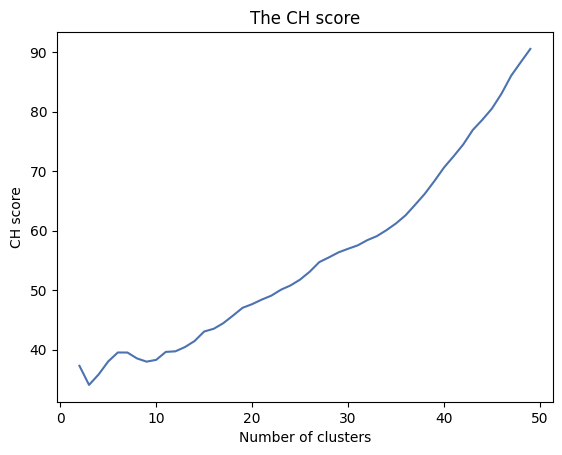

In [ ]:
calinski_harabasz_method(data, 'ward')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 10, linkage='ward')
labels = clust.fit_predict(data)

In [ ]:
calinski_harabasz_score(data, labels)

38.27941936230164

In [ ]:
cluster_dict = print_clusters(drawdowns_df_cut, labels)

Cluster 8: AAPL, BIIB, BK, COP, IT, JNJ, JPM, M, QCOM
Cluster 3: ABBV, AMGN, BKNG, CVX, EA, GM, HPQ, IBM, INCY, INTC, MA, META, MS, SLB, STT, STX, XOM
Cluster 9: ADBE, PSA
Cluster 2: ADSK, AMZN, BLK, CCI, GOOG, MSFT, T
Cluster 1: ATVI, AVGO, EQIX, LLY, MRK, VRTX, WFC
Cluster 7: AZN, GILD, GS, LUMN, NVDA, PLD, SCHW, SPG, VZ
Cluster 0: BAC, C, COST, EBAY, EOG, F, JWN, PFE, V, WMT
Cluster 5: MU
Cluster 6: NFLX
Cluster 4: ORCL, REGN, TXN, UNH


In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio

['AAPL', 'STX', 'PSA', 'MSFT', 'EQIX', 'PLD', 'COST', 'MU', 'NFLX', 'ORCL']

In [ ]:
weights = optimize_portfolio(drawdowns_df_cut, portfolio, (0, 0.2))

OrderedDict([('AAPL', 0.0), ('STX', 0.17367), ('PSA', 0.2), ('MSFT', 0.2), ('EQIX', 0.0), ('PLD', 0.2), ('COST', 0.2), ('MU', 0.0), ('NFLX', 0.0), ('ORCL', 0.02633)])

Expected annual return: 69.7%
Annual volatility: 14.8%
Sharpe Ratio: 4.57


##### Cheking stability

In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2022-01-01',
                    '2022-02-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -6.8%
Annual volatility: 5.7%
Sharpe Ratio: -1.19
(-0.06842440494224063, 0.05732270867969044, -1.1936701268703922)
Beta: 0.9103595074438168
Cumulative return: -6.53%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2022-01-01',
                    '2022-03-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -9.0%
Annual volatility: 8.4%
Sharpe Ratio: -1.07
(-0.09010102276953559, 0.08411076220248721, -1.071218716965464)
Beta: 0.8868278220493836
Cumulative return: -8.8%
Index stats
Expected return: -10.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2022-01-01',
                    '2022-04-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -2.8%
Annual volatility: 10.9%
Sharpe Ratio: -0.26
(-0.02832511896718906, 0.10933769795722635, -0.25906086826768604)
Beta: 0.8837366501659093
Cumulative return: -2.8%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2022-02-01',
                    '2022-03-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -2.5%
Annual volatility: 6.4%
Sharpe Ratio: -0.39
(-0.025238036740853415, 0.06417569103664038, -0.3932647445345629)
Beta: 0.9124251781748496
Cumulative return: -2.4%
Index stats
Expected return: -5.3%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2022-03-01',
                    '2022-04-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 6.8%
Annual volatility: 7.0%
Sharpe Ratio: 0.97
(0.06771252041274375, 0.07004399396459289, 0.9667141546350471)
Beta: 0.9082497150129064
Cumulative return: 6.47%
Index stats
Expected return: 5.6%
Volatility: 0.0%


#### Complete Linkage

##### Building a portfolio

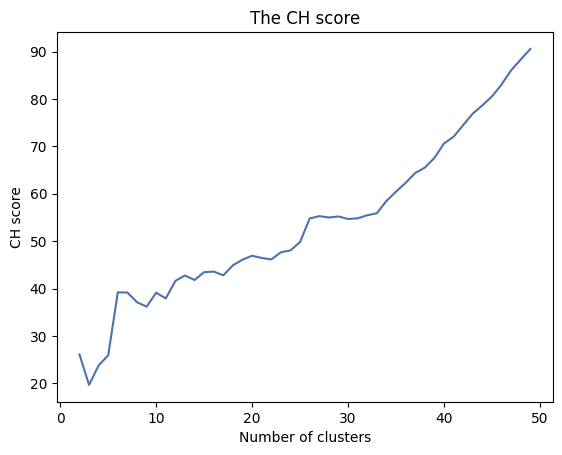

In [ ]:
calinski_harabasz_method(data, 'complete')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 6, linkage='complete')
labels = clust.fit_predict(data)

In [ ]:
calinski_harabasz_score(data, labels)

39.21235720094151

In [ ]:
cluster_dict = print_clusters(drawdowns_df, labels)

Cluster 2: AAPL, ABBV, AMGN, BIIB, BK, BKNG, COP, CVX, EA, GM, HPQ, IBM, INCY, INTC, IT, JPM, MA, META, MS, QCOM, SLB, STT, STX, XOM
Cluster 1: ADBE, ORCL, PSA, REGN, TXN, UNH
Cluster 3: ADSK, AMZN, AZN, BLK, CCI, GILD, GOOG, GS, JNJ, LUMN, M, MSFT, NVDA, PLD, SCHW, SPG, T, VZ
Cluster 0: ATVI, AVGO, EQIX, LLY, MRK, NFLX, VRTX, WFC
Cluster 4: BAC, C, COST, EBAY, EOG, F, JWN, PFE, V, WMT
Cluster 5: MU


In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
portfolio

['AAPL', 'PSA', 'MSFT', 'EQIX', 'COST', 'MU']

In [ ]:
weights = optimize_portfolio(drawdowns_df_cut, portfolio, (0, 0.2))

OrderedDict([('AAPL', 0.1835), ('PSA', 0.2), ('MSFT', 0.2), ('EQIX', 0.15618), ('COST', 0.2), ('MU', 0.06032)])

Expected annual return: 48.8%
Annual volatility: 15.1%
Sharpe Ratio: 3.10


##### Cheking stability

In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2022-01-01',
                    '2022-02-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -8.4%
Annual volatility: 6.4%
Sharpe Ratio: -1.31
(-0.0843832265766626, 0.06431738437284647, -1.311981626732438)
Beta: 1.1440744987323685
Cumulative return: -8.06%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2022-01-01',
                    '2022-03-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -9.2%
Annual volatility: 8.9%
Sharpe Ratio: -1.04
(-0.09235044838986059, 0.0890249585553548, -1.0373545788559737)
Beta: 0.9931581333599062
Cumulative return: -9.02%
Index stats
Expected return: -10.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2022-01-01',
                    '2022-04-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -2.6%
Annual volatility: 11.6%
Sharpe Ratio: -0.23
(-0.026274638391882037, 0.11564418716378022, -0.22720241316297873)
Beta: 0.9963289475774485
Cumulative return: -2.59%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2022-02-01',
                    '2022-03-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -1.0%
Annual volatility: 6.4%
Sharpe Ratio: -0.16
(-0.010134347182343666, 0.06370235737949434, -0.1590890447267167)
Beta: 0.9335051755728017
Cumulative return: -0.97%
Index stats
Expected return: -5.3%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2022-03-01',
                    '2022-04-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 7.3%
Annual volatility: 7.4%
Sharpe Ratio: 0.99
(0.07292451182085832, 0.07389777394171561, 0.9868296151704798)
Beta: 1.0382760293322784
Cumulative return: 6.97%
Index stats
Expected return: 5.6%
Volatility: 0.0%


#### Average Linkage

##### Building a portfolio

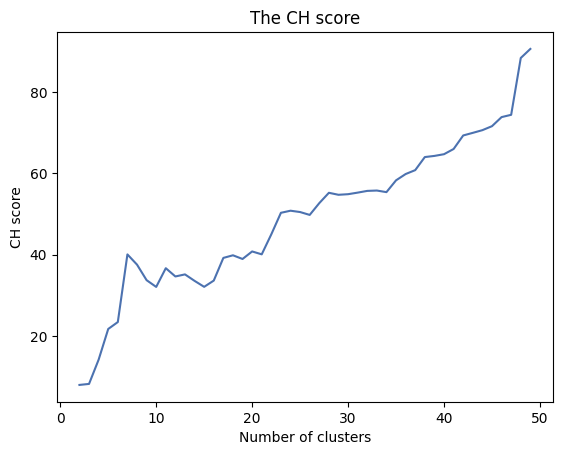

In [ ]:
calinski_harabasz_method(data, 'average')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 10, linkage='average')
labels = clust.fit_predict(data)

In [ ]:
calinski_harabasz_score(data, labels)

32.07316579580792

In [ ]:
cluster_dict = print_clusters(drawdowns_df, labels)

Cluster 6: AAPL, ABBV, AMGN, BIIB, BK, BKNG, COP, CVX, EA, GM, HPQ, IBM, INCY, INTC, IT, JPM, MA, META, MS, QCOM, SLB, STT, STX, XOM
Cluster 3: ADBE, PSA
Cluster 0: ADSK, AMZN, AZN, BAC, BLK, C, CCI, COST, F, GILD, GOOG, GS, JNJ, LUMN, M, MSFT, NVDA, PLD, SCHW, SPG, T, VZ
Cluster 4: ATVI, AVGO, MRK, VRTX, WFC
Cluster 2: EBAY, ORCL, REGN, TXN, UNH
Cluster 1: EOG, JWN, V, WMT
Cluster 9: EQIX, LLY
Cluster 5: MU
Cluster 7: NFLX
Cluster 8: PFE


In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
# portfolio

In [ ]:
weights = optimize_portfolio(drawdowns_df_cut, portfolio, (0, 0.2))

OrderedDict([('AAPL', 0.03765), ('PSA', 0.2), ('COST', 0.2), ('AVGO', 0.2), ('EBAY', 0.07486), ('WMT', 0.0), ('EQIX', 0.08074), ('MU', 0.00675), ('NFLX', 0.0), ('PFE', 0.2)])

Expected annual return: 56.7%
Annual volatility: 13.4%
Sharpe Ratio: 4.07


##### Cheking stability

In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2022-01-01',
                    '2022-02-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -8.4%
Annual volatility: 5.6%
Sharpe Ratio: -1.50
(-0.08358738195287839, 0.0556628746264919, -1.5016720303032327)
Beta: 0.9795373781532185
Cumulative return: -7.98%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2022-01-01',
                    '2022-03-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -11.7%
Annual volatility: 7.7%
Sharpe Ratio: -1.52
(-0.11724630910100792, 0.07719152858519836, -1.518901247973086)
Beta: 0.8627451123296404
Cumulative return: -11.45%
Index stats
Expected return: -10.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2022-01-01',
                    '2022-04-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -2.4%
Annual volatility: 9.9%
Sharpe Ratio: -0.25
(-0.024409482005498882, 0.09876040242750596, -0.2471585919611497)
Beta: 0.8295031402891097
Cumulative return: -2.41%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2022-02-01',
                    '2022-03-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -3.9%
Annual volatility: 5.6%
Sharpe Ratio: -0.70
(-0.039060208891914854, 0.05593347619831448, -0.6983332978165928)
Beta: 0.8206609259797302
Cumulative return: -3.73%
Index stats
Expected return: -5.3%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2022-03-01',
                    '2022-04-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 10.7%
Annual volatility: 5.7%
Sharpe Ratio: 1.87
(0.10687450934891388, 0.057165227062052806, 1.8695720255410109)
Beta: 0.7594022024294041
Cumulative return: 10.22%
Index stats
Expected return: 5.6%
Volatility: 0.0%


#### Single Linkage

##### Building a portfolio

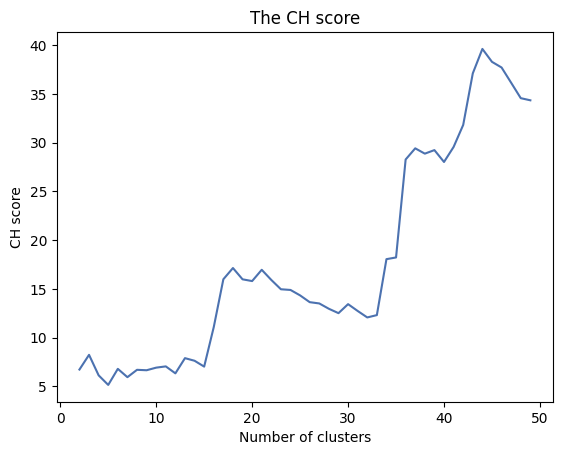

In [ ]:
calinski_harabasz_method(data, 'single')

In [ ]:
clust = AgglomerativeClustering(n_clusters = 10, linkage='single')
labels = clust.fit_predict(data)

In [ ]:
calinski_harabasz_score(data, labels)

6.924782628835349

In [ ]:
cluster_dict = print_clusters(drawdowns_df, labels)

Cluster 0: AAPL, ABBV, ADSK, AMGN, AMZN, ATVI, AVGO, AZN, BAC, BIIB, BK, BKNG, BLK, C, CCI, COP, COST, CVX, EA, EBAY, F, GILD, GM, GOOG, GS, HPQ, IBM, INCY, INTC, IT, JNJ, JPM, JWN, LUMN, M, MA, META, MRK, MS, NVDA, ORCL, PLD, QCOM, REGN, SCHW, SLB, SPG, STT, STX, TXN, VRTX, VZ, WFC, WMT, XOM
Cluster 1: ADBE, PSA
Cluster 6: EOG
Cluster 2: EQIX, LLY
Cluster 3: MSFT, T
Cluster 7: MU
Cluster 5: NFLX
Cluster 9: PFE
Cluster 4: UNH
Cluster 8: V


In [ ]:
portfolio = get_portfolio_tickers(cluster_dict, returns)

In [ ]:
# portfolio

In [ ]:
weights = optimize_portfolio(drawdowns_df_cut, portfolio, (0, 0.2))

OrderedDict([('COST', 0.158), ('PSA', 0.2), ('EOG', 0.10297), ('EQIX', 0.0), ('MSFT', 0.18113), ('MU', 0.0), ('NFLX', 0.0), ('PFE', 0.2), ('UNH', 0.15791), ('V', 0.0)])

Expected annual return: 63.0%
Annual volatility: 11.8%
Sharpe Ratio: 5.19


##### Cheking stability

In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2022-01-01',
                    '2022-02-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -3.3%
Annual volatility: 4.4%
Sharpe Ratio: -0.75
(-0.03312755070946339, 0.043959012852742715, -0.7536008786283852)
Beta: 0.6627307239948397
Cumulative return: -3.18%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2022-01-01',
                    '2022-03-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -5.4%
Annual volatility: 6.5%
Sharpe Ratio: -0.82
(-0.053685765785321964, 0.06511622279856255, -0.8244606870303154)
Beta: 0.6327296038289731
Cumulative return: -5.26%
Index stats
Expected return: -10.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2022-01-01',
                    '2022-04-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 3.1%
Annual volatility: 8.2%
Sharpe Ratio: 0.37
(0.030571590023470343, 0.08246296041800197, 0.37073117274111894)
Beta: 0.6116763744255597
Cumulative return: 3.0%
Index stats
Expected return: -5.2%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2022-02-01',
                    '2022-03-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: -2.4%
Annual volatility: 5.0%
Sharpe Ratio: -0.48
(-0.024020563469567924, 0.050300273429377255, -0.4775433975183723)
Beta: 0.6411754173994303
Cumulative return: -2.29%
Index stats
Expected return: -5.3%
Volatility: 0.0%


In [ ]:
get_portfolio_stats(drawdowns_df,
                    index_df,
                    '2022-03-01',
                    '2022-04-01',
                    portfolio,
                    weights)

Portfolio stats
Expected annual return: 9.3%
Annual volatility: 4.8%
Sharpe Ratio: 1.93
(0.09339534541475654, 0.04845094019406835, 1.927627101572542)
Beta: 0.5678650718504067
Cumulative return: 8.93%
Index stats
Expected return: 5.6%
Volatility: 0.0%
